# GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [2]:
import os 
import requests
from zipfile import ZipFile 
import shutil #To copy the FER2013 and CK+ images to the folder
import pandas as pd #To create dataframe
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split #Split the train, test and val data
from collections import Counter  #To count the amount of labels for each generator
from keras.preprocessing.image import ImageDataGenerator #To create the generator and iterator by dataframe or directory. Also pre-processing
import numpy as np 
import matplotlib.pyplot as plt #Chart
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint #to create a checkpoint and save each acc in each epocs that improves
from datetime import datetime #to tensorboard
from tensorflow.keras.callbacks import TensorBoard #to tensorboard
from keras.applications import InceptionResNetV2 
from keras.models import Sequential, Model 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D 
import PIL

from keras.applications import EfficientNetB0
from keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D, Input
from keras.models import Model
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from keras.applications import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Flatten,GaussianNoise, BatchNormalization, Conv2D, Input
from tensorflow.keras.optimizers import Adam,SGD
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, LearningRateScheduler
import math
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
from kerastuner.tuners import RandomSearch
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt


C:\Users\bryan\AppData\Local\Temp\ipykernel_10160\4280761065.py:41: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
import random, os
import numpy as np
import tensorflow as tf
#SET SEED
def set_seed(seed=42):
  np.random.seed(seed) 
  tf.random.set_seed(seed) 
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Data analysis

In [4]:
train_dir = 'fer2013/train' #Directory
test_dir = 'fer2013/test' #Directory

In [15]:
def count_images_byClass(directory): #To count the images
    classes = sorted(os.listdir(directory))
    num_images = []
    for clase in classes:
        class_dir = os.path.join(directory, clase)
        num_images.append(len(os.listdir(class_dir)))
    return classes, num_images

train_classes, train_num_images = count_images_byClass(train_dir)
test_classes, test_num_images = count_images_byClass(test_dir)


print("Names of classes in train set: ", train_classes)
print("Numbers by classes in train set", train_num_images)

print("Names of classes in test set: ", test_classes)
print("Numbers by classes in test set", test_num_images)

Names of classes in train set:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Numbers by classes in train set [3995, 436, 4097, 7215, 4965, 4830, 3171]
Names of classes in test set:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Numbers by classes in test set [958, 111, 1024, 1774, 1233, 1247, 831]


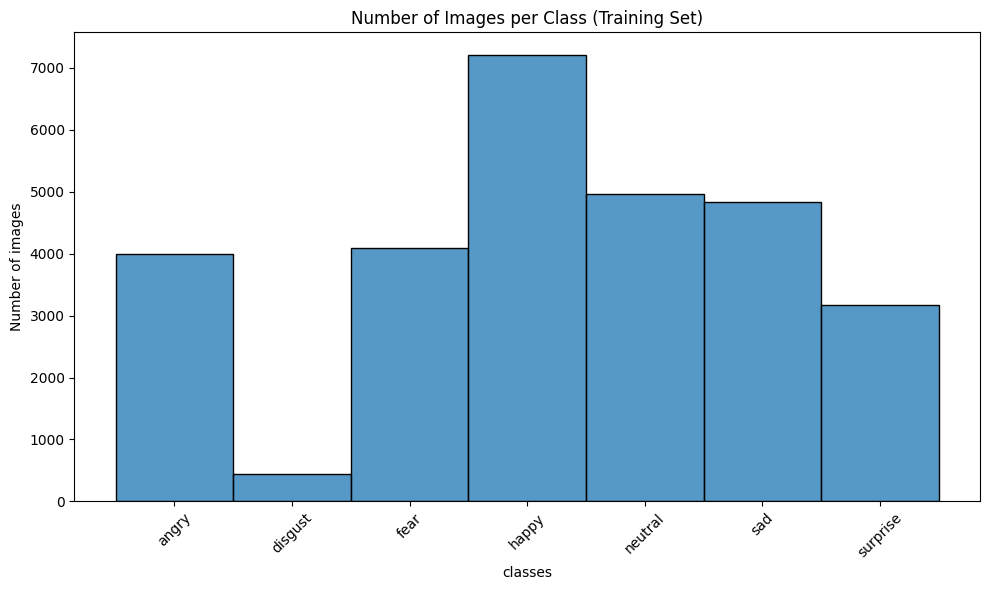

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(x=train_classes, weights=train_num_images, bins=len(train_classes), kde=False)
plt.xticks(rotation=45)
plt.xlabel('classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Training Set)')
plt.tight_layout()
plt.show()

We see the imbalance of the training set for the disgust emotion

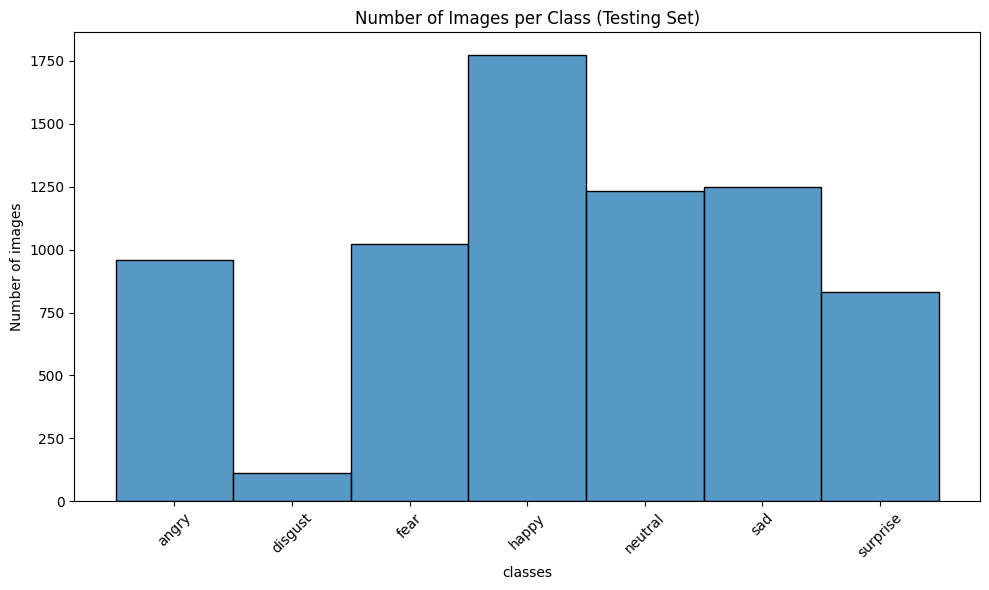

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(x=test_classes, weights=test_num_images, bins=len(test_classes), kde=False)
plt.xticks(rotation=45)
plt.xlabel('classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Testing Set)')
plt.tight_layout()
plt.show()

We see the imbalance of the testing set for the disgust emotion

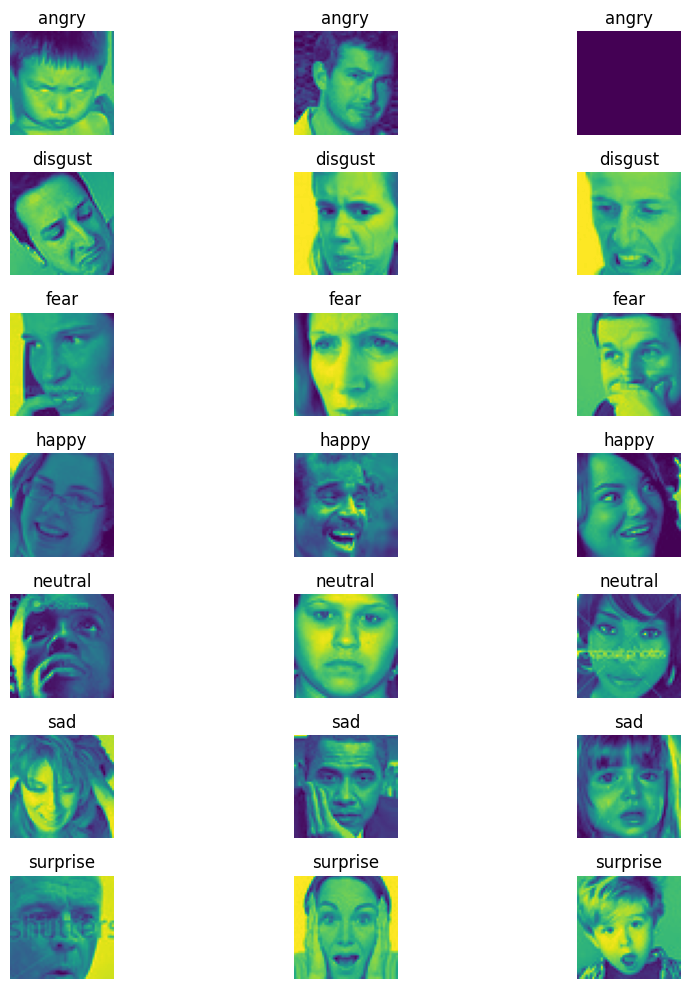

In [18]:
def ShowExamples(directory, classes, num_examples=3): #Show examples of the training set
    plt.figure(figsize=(10, 10))
    for i, clase in enumerate(classes):
        class_dir = os.path.join(directory, clase)
        image_files = os.listdir(class_dir)[:num_examples]
        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)
            plt.subplot(len(classes), num_examples, i * num_examples + j + 1)
            plt.imshow(image)
            plt.title(clase)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

ShowExamples(train_dir, train_classes, num_examples=3)


We see the first ten training images

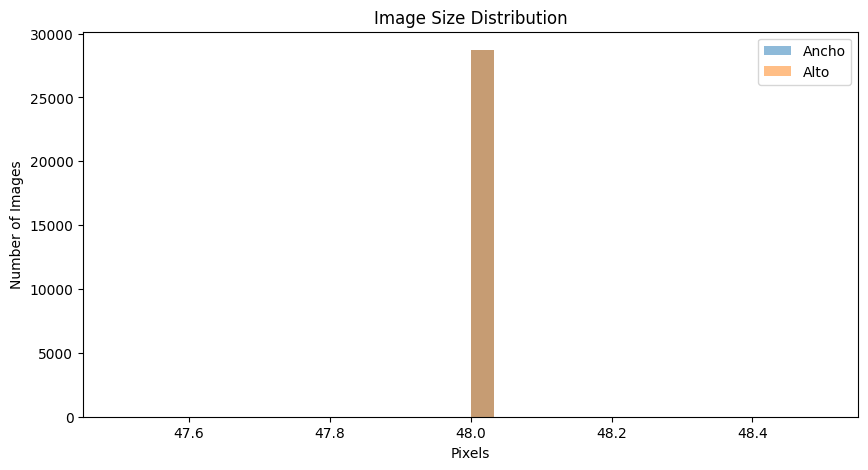

In [30]:
def image_size_distribution(directory): # To see the size for each images
    image_sizes = []
    for clase in os.listdir(directory):
        class_dir = os.path.join(directory, clase)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)
            width, height = image.size
            image_sizes.append((width, height))
    image_sizes = np.array(image_sizes)
    
    plt.figure(figsize=(10, 5))
    plt.hist(image_sizes[:, 0], bins=30, alpha=0.5, label='Ancho')
    plt.hist(image_sizes[:, 1], bins=30, alpha=0.5, label='Alto')
    plt.title('Image Size Distribution')
    plt.xlabel('Pixels')
    plt.ylabel('Number of Images')
    plt.legend()
    plt.show()

image_size_distribution(train_dir)


We see the size for each images

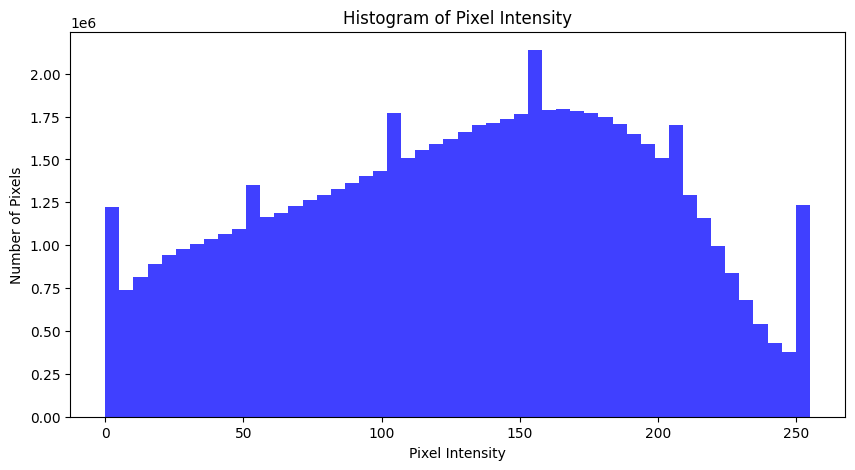

In [31]:
def intensity_histogram(directory): # To see the histogram of pixel intensity
    pixel_intensities = []
    for clase in os.listdir(directory):
        class_dir = os.path.join(directory, clase)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path).convert('L')  
            intensities = np.array(image).flatten()
            pixel_intensities.extend(intensities)
    pixel_intensities = np.array(pixel_intensities)
    
    plt.figure(figsize=(10, 5))
    plt.hist(pixel_intensities, bins=50, alpha=0.75, color='b')
    plt.title('Histogram of Pixel Intensity')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Number of Pixels')
    plt.show()

intensity_histogram(train_dir)


In [37]:
data_dir = 'fer2013/train' #se define la ubicación de la carpeta de los datos
filepath = [] #se define la lista donde van a estar todas las ubicaciones de cada imagen
labels = [] #se define la lista donde va a estar todos los labels
classes = os.listdir(data_dir) #lista las clases

for classfolder in classes: #por cada clase
    folderclass = os.path.join(data_dir, classfolder) #obtiene la ruta
    file_list = os.listdir(folderclass) #ingresa y los lista
    for files in file_list: #por cada archivo dentro de las clases
      pathfile = os.path.join(folderclass,files) #obtiene la ruta
      filepath.append(pathfile) #ingresa el path del file en filepath
      labels.append(classfolder) #ingresa el labels del file en labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Se crea un dataframe que tenga una columna llamada filepath, donde va a tener la lista de las ubicaciones de las imagenes
#Se crea una columna llamada labels que va a tener la lista de los labels de cada file (filepath)

In [38]:
datos.describe()

filepath labels
count                                       28709  28709
unique                                      28709      7
top     fer2013/train\angry\Training_10118481.jpg  happy
freq                                            1   7215

The description of the FER2013 dataset

In [39]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  28709 non-null  object
 1   labels    28709 non-null  object
dtypes: object(2)
memory usage: 448.7+ KB


# Data augmentation and definition of importance by classes (balancing) in the train set

balancing by weighted weights

In [4]:
img_shape = 48
batch_size = 64

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,    #Normalization            
    rotation_range=10,   #rotation range between -10 to 10
    zoom_range=0.2,      #zoom range       
    width_shift_range=0.1,   # width shift range     
    height_shift_range=0.1,  # height shift range         
    horizontal_flip=True,    # horizontal flip in true     
    fill_mode='nearest',          
    validation_split=0.2    #train is divided into 20% for validation      
)

val_datagen = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       #48x48
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=64,                # 64 batch
    seed = 42,
    subset="training",            #Training set  
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),   #48x48    
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=64,                # 64 batch 
    seed = 42,
    subset="validation",    #validation set        
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),   #48x48    
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=64,                # 64 batch 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator.classes)

# balancing by weighted weights 
class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


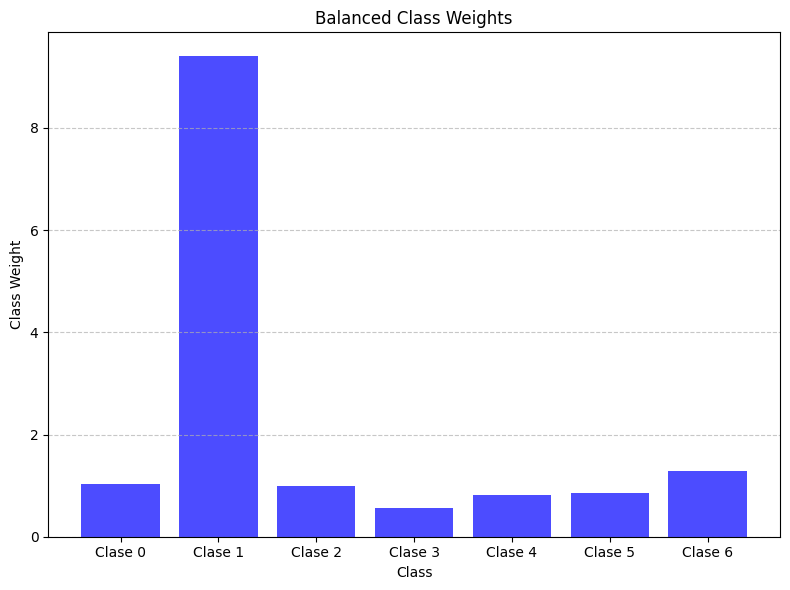

In [ ]:
# To show the importance applied in the balancing for each class
plt.figure(figsize=(8, 6))
plt.bar(class_weights_dict.keys(), class_weights_dict.values(), color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Class Weight')
plt.title('Balanced Class Weights')
plt.xticks(list(class_weights_dict.keys()), labels=[f'Clase {k}' for k in class_weights_dict.keys()])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
class_indices = train_generator.class_indices
class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Models with 1 dataset (FER2013)

## Model 1 CNN 66.49%

In [15]:
model_MoreData = tf.keras.Sequential([

        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,3)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_MoreData.compile(optimizer=optimiser, #The model is created
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_MoreData.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       2

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models/test1_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test1_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test1_MoreData/64batch', exist_ok=True)



log_dir = "logs/test1_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

training model

In [ ]:
historytest1_MoreData = model_MoreData.fit(x = train_generator,epochs = 300,validation_data = val_generator, class_weight=class_weights_dict, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)
#The model uses the weights balanced for each class

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 9.9602 - accuracy: 0.1587
Epoch 1: val_accuracy improved from -inf to 0.16670, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_1_0.1667.h5
359/359 [==============================] - 47s 125ms/step - loss: 9.9602 - accuracy: 0.1587 - val_loss: 9.3066 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 9.2297 - accuracy: 0.1724
Epoch 2: val_accuracy improved from 0.16670 to 0.19648, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_2_0.1965.h5
359/359 [==============================] - 43s 120ms/step - loss: 9.2297 - accuracy: 0.1724 - val_loss: 8.6808 - val_accuracy: 0.1965 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 8.5392 - accuracy: 0.1790
Epoch 3: val_accuracy did not improve from 0.19648
359/359 [==============================] - 44s 121ms/step - loss: 8.5392 - accuracy: 

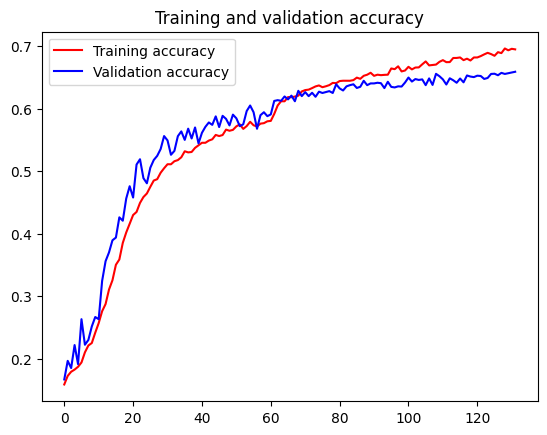

<Figure size 640x480 with 0 Axes>

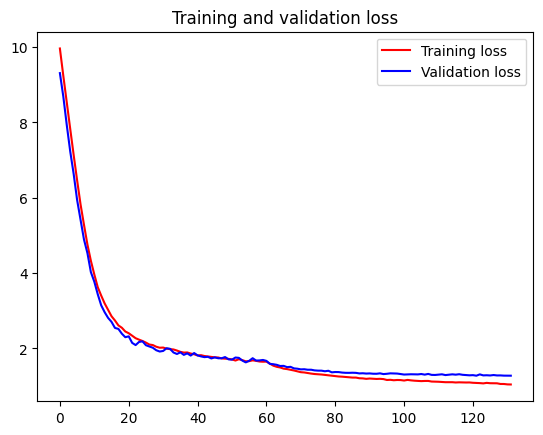

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest1_MoreData.history['accuracy']
val_acc = historytest1_MoreData.history['val_accuracy']
loss = historytest1_MoreData.history['loss']
val_loss = historytest1_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData_load = tf.keras.models.load_model('models/test1_MoreData/64batch/best_model_ModelPaper2_132_0.6593.h5')

y_true = test_generator.classes #Get all classes of y_test
y_pred = model_moreData_load.predict(test_generator).argmax(axis=1)

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 28s 194ms/step
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       958
           1       0.56      0.68      0.61       111
           2       0.58      0.38      0.46      1024
           3       0.89      0.85      0.87      1774
           4       0.57      0.72      0.64      1233
           5       0.61      0.47      0.53      1247
           6       0.72      0.85      0.78       831

    accuracy                           0.66      7178
   macro avg       0.64      0.66      0.64      7178
weighted avg       0.67      0.66      0.66      7178

<function confusion_matrix at 0x000001870AF1AEF0>


In [ ]:
model_MoreData.evaluate(test_generator)

113/113 [==============================] - 13s 111ms/step - loss: 1.2603 - accuracy: 0.6649


[1.2603180408477783, 0.6649484634399414]

## Model 2 ResNet50V2 58.63%

In [ ]:
from keras.applications import ResNet50V2
from keras.optimizers import Adamax

input_shape = (48, 48, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape) #Pre-training model with imagenet weights

model2_MoreData = Sequential([
                    #tf.keras.layers.Resizing(75,75),
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=1e-4)

model2_MoreData.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2_MoreData.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 batch_normalization_63 (Bat  (None, 2, 2, 2048)       8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_37 (Dense)            (None, 128)               262272    
                                                                 
 dropout_70 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 128)             

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test2_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test2_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test2_MoreData/64batch', exist_ok=True)



log_dir = "logs/test2_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest2_MoreData = model2_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback, reduce_lr])

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 2.3210 - accuracy: 0.1469
Epoch 1: val_accuracy improved from -inf to 0.14632, saving model to models/test2_MoreData/64batch\best_model_ModelPaper2_1_0.1463.h5
359/359 [==============================] - 64s 155ms/step - loss: 2.3210 - accuracy: 0.1469 - val_loss: 1.9672 - val_accuracy: 0.1463 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 2.0325 - accuracy: 0.1501
Epoch 2: val_accuracy did not improve from 0.14632
359/359 [==============================] - 51s 141ms/step - loss: 2.0325 - accuracy: 0.1501 - val_loss: 1.9488 - val_accuracy: 0.1430 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 1.9771 - accuracy: 0.1541
Epoch 3: val_accuracy improved from 0.14632 to 0.16704, saving model to models/test2_MoreData/64batch\best_model_ModelPaper2_3_0.1670.h5
359/359 [==============================] - 52s 146ms/step - loss: 1.9771 - accuracy: 

In [ ]:
model2_MoreData = tf.keras.models.load_model('models/test2_MoreData/64batch/best_model_ModelPaper2_68_0.5788.h5')
model2_MoreData.evaluate(test_generator)

113/113 [==============================] - 6s 46ms/step - loss: 1.1586 - accuracy: 0.5864


[1.1586318016052246, 0.5863750576972961]

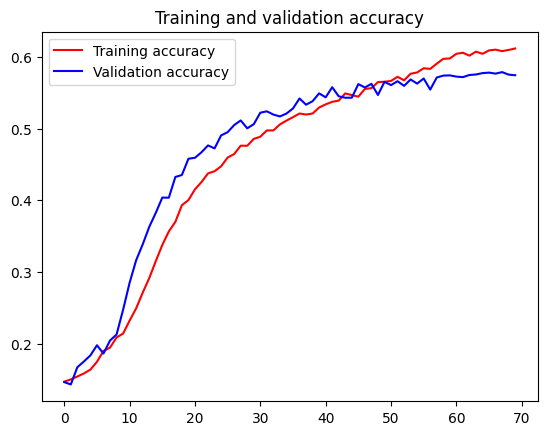

<Figure size 640x480 with 0 Axes>

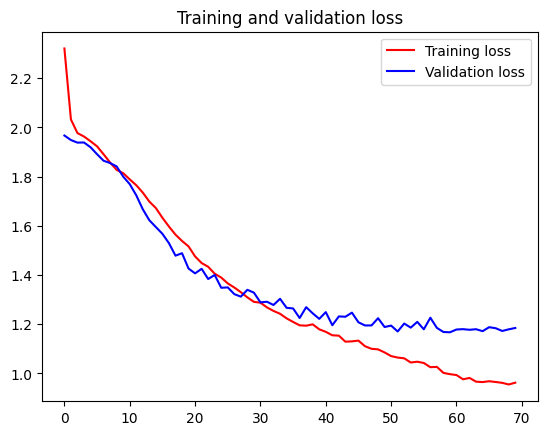

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest2_MoreData.history['accuracy']
val_acc = historytest2_MoreData.history['val_accuracy']
loss = historytest2_MoreData.history['loss']
val_loss = historytest2_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 3 VGG19 64.44%

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50V2, VGG19
from keras.regularizers import l2



input_shape = (48, 48, 3)

base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)

model3_MoreData = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=1e-4)

model3_MoreData.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model3_MoreData.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_72 (Bat  (None, 1, 1, 512)        2048      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_49 (Dense)            (None, 256)               131328    
                                                                 
 dropout_82 (Dropout)        (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 128)             

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test3_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test3_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test3_MoreData/64batch', exist_ok=True)



log_dir = "logs/test3_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest3_MoreData = model3_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 2.4205 - accuracy: 0.1604
Epoch 1: val_accuracy improved from -inf to 0.15729, saving model to models/test3_MoreData/64batch\best_model_ModelPaper2_1_0.1573.h5
359/359 [==============================] - 63s 168ms/step - loss: 2.4205 - accuracy: 0.1604 - val_loss: 2.5168 - val_accuracy: 0.1573 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 2.2789 - accuracy: 0.2170
Epoch 2: val_accuracy improved from 0.15729 to 0.25553, saving model to models/test3_MoreData/64batch\best_model_ModelPaper2_2_0.2555.h5
359/359 [==============================] - 57s 159ms/step - loss: 2.2789 - accuracy: 0.2170 - val_loss: 2.1640 - val_accuracy: 0.2555 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 2.1738 - accuracy: 0.2679
Epoch 3: val_accuracy improved from 0.25553 to 0.28479, saving model to models/test3_MoreData/64batch\best_model_ModelPaper2_3_0.2848.h5

In [ ]:
model3_MoreData.evaluate(test_generator)

113/113 [==============================] - 9s 80ms/step - loss: 1.1479 - accuracy: 0.6445


[1.1479302644729614, 0.6444692015647888]

In [6]:
model3_MoreData_load = tf.keras.models.load_model('models/OtherModels/VGG19/best_model_ModelPaper2_37_0.6438.h5')
model3_MoreData_load.evaluate(test_generator)

113/113 [==============================] - 32s 224ms/step - loss: 1.1479 - accuracy: 0.6445


[1.1479302644729614, 0.6444692015647888]

In [11]:
y_true = test_generator.classes
y_pred = model3_MoreData_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 45ms/step
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       958
           1       0.64      0.61      0.63       111
           2       0.56      0.35      0.43      1024
           3       0.87      0.83      0.85      1774
           4       0.52      0.72      0.61      1233
           5       0.55      0.44      0.49      1247
           6       0.72      0.83      0.77       831

    accuracy                           0.64      7178
   macro avg       0.63      0.63      0.62      7178
weighted avg       0.65      0.64      0.64      7178

<function confusion_matrix at 0x000001B68BA7A050>


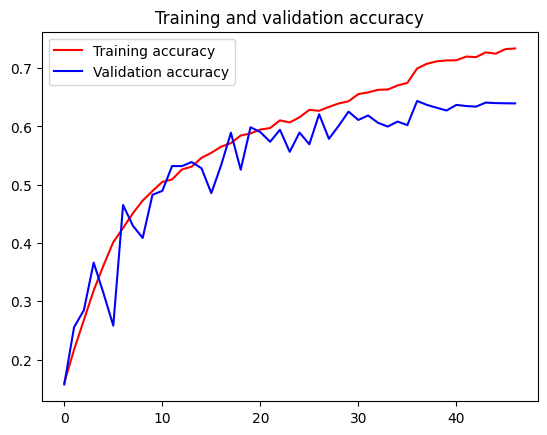

<Figure size 640x480 with 0 Axes>

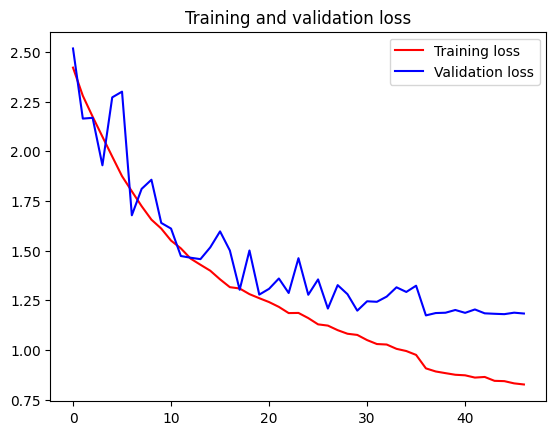

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest3_MoreData.history['accuracy']
val_acc = historytest3_MoreData.history['val_accuracy']
loss = historytest3_MoreData.history['loss']
val_loss = historytest3_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 4 CNN 58.24%

In [6]:

input_shape = (48, 48, 3)
input_layer = Input(shape=input_shape)

#Modelo VGGNet
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(2048, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.5)(x)

output_layer = Dense(7, activation='softmax')(x)


model4_moreData = Model(inputs=input_layer, outputs=output_layer)

model4_moreData.summary()

model4_moreData.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

In [7]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test4_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test4_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test4_MoreData/64batch', exist_ok=True)



log_dir = "logs/test4_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [9]:
historytest4_moreData = model4_moreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr],
    shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 2.2770 - accuracy: 0.1563
Epoch 1: val_accuracy improved from -inf to 0.13796, saving model to models/test4_MoreData/64batch\best_model_ModelPaper2_1_0.1380.h5
359/359 [==============================] - 106s 273ms/step - loss: 2.2770 - accuracy: 0.1563 - val_loss: 2.2329 - val_accuracy: 0.1380 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 2.1695 - accuracy: 0.1769
Epoch 2: val_accuracy did not improve from 0.13796
359/359 [==============================] - 30s 84ms/step - loss: 2.1695 - accuracy: 0.1769 - val_loss: 2.1698 - val_accuracy: 0.1036 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 2.1450 - accuracy: 0.1782
Epoch 3: val_accuracy improved from 0.13796 to 0.23724, saving model to models/test4_MoreData/64batch\best_model_ModelPaper2_3_0.2372.h5
359/359 [==============================] - 30s 84ms/step - loss: 2.1450 - accuracy: 0

In [12]:
model4_moreData.evaluate(test_generator)

113/113 [==============================] - 4s 30ms/step - loss: 1.1120 - accuracy: 0.5825


[1.112000823020935, 0.5824742317199707]

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

model4_moreData_load1 = tf.keras.models.load_model(r'models/test4_MoreData/64batch\best_model_ModelPaper2_70_0.5818.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model4_moreData_load1.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 18s 162ms/step
              precision    recall  f1-score   support

           0       0.47      0.50      0.48       958
           1       0.26      0.69      0.37       111
           2       0.45      0.27      0.33      1024
           3       0.84      0.80      0.82      1774
           4       0.49      0.66      0.56      1233
           5       0.50      0.36      0.42      1247
           6       0.67      0.81      0.73       831

    accuracy                           0.58      7178
   macro avg       0.53      0.58      0.53      7178
weighted avg       0.59      0.58      0.57      7178

<function confusion_matrix at 0x0000019B8B8C9FC0>


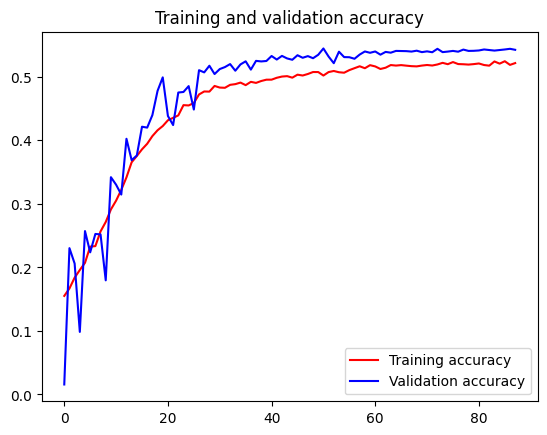

<Figure size 640x480 with 0 Axes>

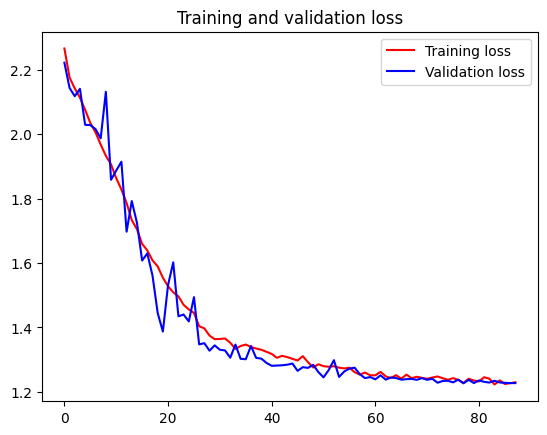

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest4_moreData.history['accuracy']
val_acc = historytest4_moreData.history['val_accuracy']
loss = historytest4_moreData.history['loss']
val_loss = historytest4_moreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 5 CNN 54.26%

In [13]:
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, Dense,Flatten
from keras.optimizers import Adam

InputKeras = Input(shape=(48,48,3))


x = Conv2D(256, (3,3), activation="relu",padding="same")(InputKeras)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3,3), activation="relu",padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3,3), activation="relu",padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3,3), activation="relu",padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1792, activation="relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(7, activation="softmax")(x)

Model5_MoreData = Model(inputs=InputKeras, outputs=prediction)

Model5_MoreData.compile(loss="categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])

Model5_MoreData.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 256)       7168      
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 256)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 256)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 256)       5900

In [14]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test5_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test5_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test5_MoreData/64batch', exist_ok=True)



log_dir = "logs/test5_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [16]:
historytest5_moreData = Model5_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr],
    shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 2.5627 - accuracy: 0.1725
Epoch 1: val_accuracy improved from -inf to 0.04059, saving model to models/test5_MoreData/64batch\best_model_ModelPaper2_1_0.0406.h5
359/359 [==============================] - 38s 103ms/step - loss: 2.5627 - accuracy: 0.1725 - val_loss: 3.5350 - val_accuracy: 0.0406 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 1.9879 - accuracy: 0.1873
Epoch 2: val_accuracy improved from 0.04059 to 0.23567, saving model to models/test5_MoreData/64batch\best_model_ModelPaper2_2_0.2357.h5
359/359 [==============================] - 36s 100ms/step - loss: 1.9879 - accuracy: 0.1873 - val_loss: 2.1312 - val_accuracy: 0.2357 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 1.9226 - accuracy: 0.1986
Epoch 3: val_accuracy improved from 0.23567 to 0.25274, saving model to models/test5_MoreData/64batch\best_model_ModelPaper2_3_0.2527.h5

In [17]:
Model5_MoreData.evaluate(test_generator)

113/113 [==============================] - 7s 59ms/step - loss: 1.2132 - accuracy: 0.5426


[1.2132130861282349, 0.5426302552223206]

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

Model5_MoreData = tf.keras.models.load_model(r'models/test5_MoreData/64batch\best_model_ModelPaper2_61_0.5307.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = Model5_MoreData.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 34ms/step
              precision    recall  f1-score   support

           0       0.41      0.53      0.46       958
           1       0.18      0.73      0.29       111
           2       0.39      0.18      0.25      1024
           3       0.84      0.76      0.80      1774
           4       0.49      0.61      0.54      1233
           5       0.49      0.28      0.36      1247
           6       0.57      0.82      0.67       831

    accuracy                           0.54      7178
   macro avg       0.48      0.56      0.48      7178
weighted avg       0.56      0.54      0.53      7178

<function confusion_matrix at 0x0000019B8B8C9FC0>


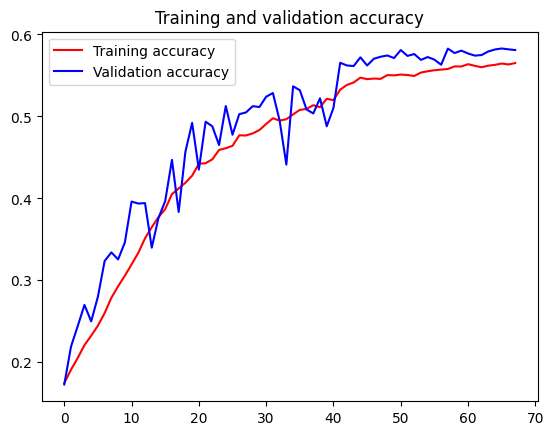

<Figure size 640x480 with 0 Axes>

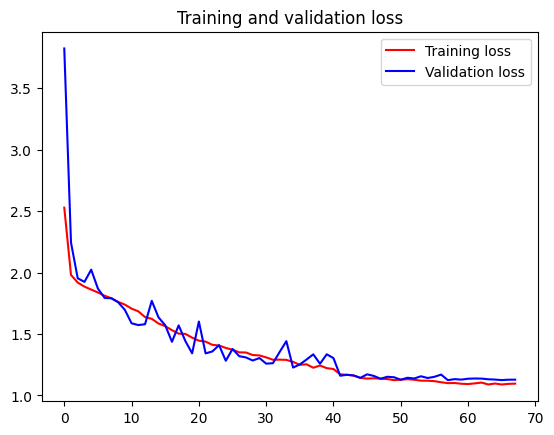

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest5_moreData.history['accuracy']
val_acc = historytest5_moreData.history['val_accuracy']
loss = historytest5_moreData.history['loss']
val_loss = historytest5_moreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 6 CNN 65.28%

In [ ]:
fernet = tf.keras.models.Sequential()   

fernet.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
fernet.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
fernet.add(BatchNormalization())
fernet.add(MaxPooling2D(2, 2))
fernet.add(Dropout(0.3))

fernet.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
fernet.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
fernet.add(BatchNormalization())
fernet.add(MaxPooling2D(pool_size=(2, 2)))
fernet.add(Dropout(0.3))

fernet.add(Flatten())
fernet.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
fernet.add(Dropout(0.5))
    
fernet.add(Dense(7, activation='softmax'))

fernet.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])


In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test6_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test6_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test6_MoreData/64batch', exist_ok=True)



log_dir = "logs/test6_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

hist = fernet.fit(x=train_generator,
                 validation_data=val_generator,
                 epochs=300,
                 callbacks=[early_stopping,model_checkpoint,tensorboard_callback,reduce_lr],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/300
358/358 [==============================] - ETA: 0s - loss: 20.2265 - accuracy: 0.2486
Epoch 1: val_accuracy improved from -inf to 0.30144, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_1_0.3014.h5
358/358 [==============================] - 69s 188ms/step - loss: 20.2265 - accuracy: 0.2486 - val_loss: 15.5489 - val_accuracy: 0.3014 - lr: 1.0000e-04
Epoch 2/300
358/358 [==============================] - ETA: 0s - loss: 11.6431 - accuracy: 0.2806
Epoch 2: val_accuracy improved from 0.30144 to 0.37254, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_2_0.3725.h5
358/358 [==============================] - 61s 170ms/step - loss: 11.6431 - accuracy: 0.2806 - val_loss: 8.5922 - val_accuracy: 0.3725 - lr: 1.0000e-04
Epoch 3/300
358/358 [==============================] - ETA: 0s - loss: 6.8680 - accuracy: 0.3120
Epoch 3: val_accuracy improved from 0.37254 to 0.38167, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_3_0.38

In [ ]:
fernet = tf.keras.models.load_model(r'C:\Users\bryan\OneDrive\Escritorio\Tesis\Codigo tesis\Imagen\Code 2\code3\models\test6_MoreData\64batch\best_model_ModelPaper2_37_0.6162.h5')
fernet.evaluate(test_generator)

113/113 [==============================] - 5s 40ms/step - loss: 1.4801 - accuracy: 0.6127


[1.480120062828064, 0.6127054691314697]

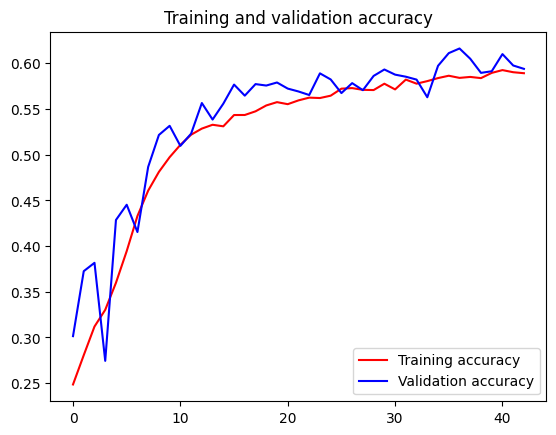

<Figure size 640x480 with 0 Axes>

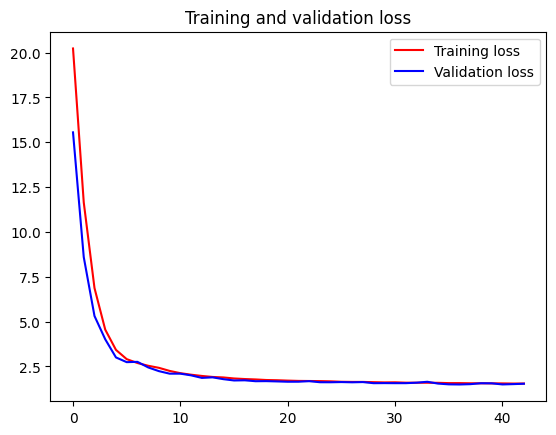

In [ ]:
import matplotlib.pyplot as plt
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

### Segunda prueba con Reduce

In [ ]:
model6_MoreData = tf.keras.models.Sequential()   

model6_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model6_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model6_MoreData.add(BatchNormalization())
model6_MoreData.add(MaxPooling2D(2, 2))
model6_MoreData.add(Dropout(0.3))

model6_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model6_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model6_MoreData.add(BatchNormalization())
model6_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model6_MoreData.add(Dropout(0.3))

model6_MoreData.add(Flatten())
model6_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model6_MoreData.add(Dropout(0.5))
    
model6_MoreData.add(Dense(7, activation='softmax'))

model6_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test6_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test6_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test6_MoreData/64batch', exist_ok=True)



log_dir = "logs/test6_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest6_MoreData = model6_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 20.5996 - accuracy: 0.1738
Epoch 1: val_accuracy improved from -inf to 0.21094, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_1_0.2109.h5
359/359 [==============================] - 55s 150ms/step - loss: 20.5996 - accuracy: 0.1738 - val_loss: 17.6076 - val_accuracy: 0.2109 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 12.7117 - accuracy: 0.1805
Epoch 2: val_accuracy improved from 0.21094 to 0.25431, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_2_0.2543.h5
359/359 [==============================] - 64s 177ms/step - loss: 12.7117 - accuracy: 0.1805 - val_loss: 10.0689 - val_accuracy: 0.2543 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 8.3226 - accuracy: 0.2176
Epoch 3: val_accuracy improved from 0.25431 to 0.25832, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_3_0.2

In [26]:
model6_MoreData_load_model = tf.keras.models.load_model('models/test6_MoreData/best_model_ModelPaper2_158_0.6468.h5')
model6_MoreData_load_model.evaluate(test_generator)

113/113 [==============================] - 8s 67ms/step - loss: 1.1721 - accuracy: 0.6528


[1.172070860862732, 0.6528280973434448]

In [27]:

predict = model6_MoreData_load_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predict, axis=-1)

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)

113/113 [==============================] - 5s 38ms/step
              precision    recall  f1-score   support

           0       0.54      0.64      0.58       958
           1       0.58      0.61      0.59       111
           2       0.58      0.37      0.45      1024
           3       0.88      0.82      0.85      1774
           4       0.55      0.72      0.63      1233
           5       0.56      0.47      0.51      1247
           6       0.71      0.84      0.77       831

    accuracy                           0.65      7178
   macro avg       0.63      0.64      0.63      7178
weighted avg       0.66      0.65      0.65      7178

[[ 611   25   58   32  112   91   29]
 [  27   68    2    2    4    6    2]
 [ 152    9  377   22  155  177  132]
 [  53    4   25 1461  132   43   56]
 [  83    2   44   60  885  128   31]
 [ 182    7  106   46  291  584   31]
 [  28    3   37   30   17   16  700]]


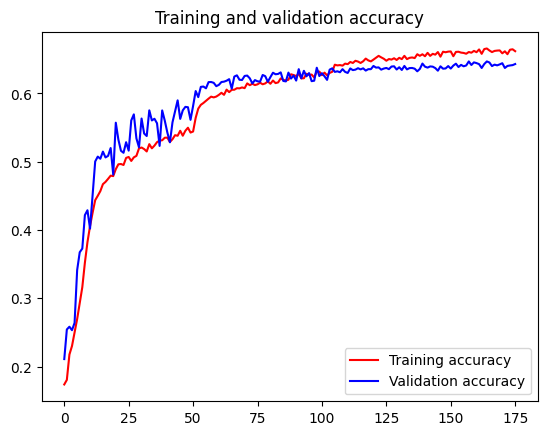

<Figure size 640x480 with 0 Axes>

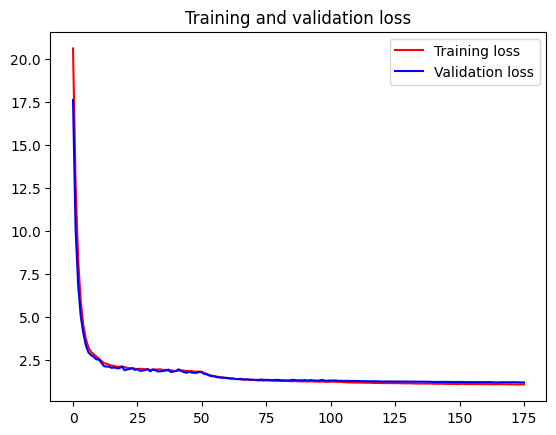

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest6_MoreData.history['accuracy']
val_acc = historytest6_MoreData.history['val_accuracy']
loss = historytest6_MoreData.history['loss']
val_loss = historytest6_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 7 CNN 67.28%

In [ ]:
model8_MoreData = tf.keras.models.Sequential()   

model8_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(2, 2))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Flatten())
model8_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData.add(Dropout(0.5))
    
model8_MoreData.add(Dense(7, activation='softmax'))

model8_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest8_MoreData = model8_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 23.3480 - accuracy: 0.1724
Epoch 1: val_accuracy improved from -inf to 0.02160, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_1_0.0216.h5
359/359 [==============================] - 48s 127ms/step - loss: 23.3480 - accuracy: 0.1724 - val_loss: 22.1749 - val_accuracy: 0.0216 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 19.3176 - accuracy: 0.1836
Epoch 2: val_accuracy improved from 0.02160 to 0.26825, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_2_0.2682.h5
359/359 [==============================] - 42s 118ms/step - loss: 19.3176 - accuracy: 0.1836 - val_loss: 17.4401 - val_accuracy: 0.2682 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 15.7457 - accuracy: 0.2066
Epoch 3: val_accuracy did not improve from 0.26825
359/359 [==============================] - 43s 119ms/step - loss: 15.7457 - ac

In [ ]:
model8_MoreData.evaluate(test_generator)

113/113 [==============================] - 9s 81ms/step - loss: 1.1480 - accuracy: 0.6729


[1.1479512453079224, 0.6728894114494324]

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData8_load1 = tf.keras.models.load_model(r'models/test8_MoreData/64batch/best_model_ModelPaper2_108_0.6600.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model_moreData8_load1.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.55      0.65      0.60       958
           1       0.58      0.65      0.61       111
           2       0.55      0.40      0.46      1024
           3       0.89      0.84      0.87      1774
           4       0.58      0.72      0.64      1233
           5       0.58      0.47      0.52      1247
           6       0.74      0.83      0.78       831

    accuracy                           0.67      7178
   macro avg       0.64      0.65      0.64      7178
weighted avg       0.67      0.67      0.66      7178

<function confusion_matrix at 0x000001870AF1AEF0>


In [33]:
model_moreData8_load1.evaluate(test_generator)

113/113 [==============================] - 5s 40ms/step - loss: 1.1665 - accuracy: 0.6656


[1.166458010673523, 0.6656450033187866]

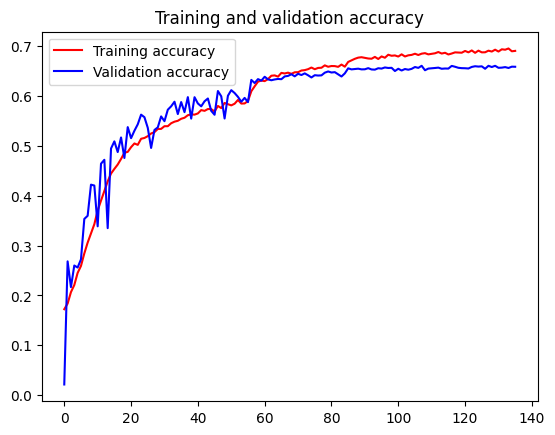

<Figure size 640x480 with 0 Axes>

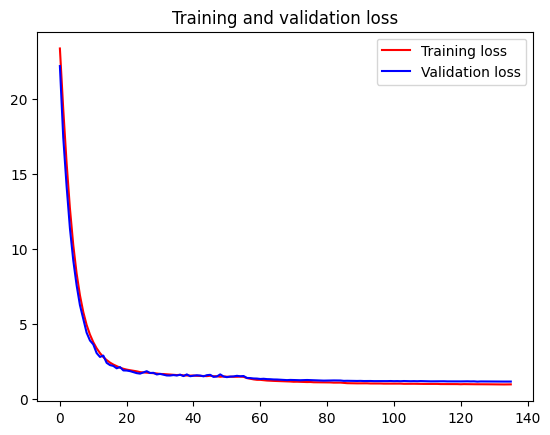

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest8_MoreData.history['accuracy']
val_acc = historytest8_MoreData.history['val_accuracy']
loss = historytest8_MoreData.history['loss']
val_loss = historytest8_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 8 CNN 52.50%

In [19]:
model9_MoreData = tf.keras.models.Sequential()   

model9_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model9_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model9_MoreData.add(BatchNormalization())
model9_MoreData.add(MaxPooling2D(2, 2))
model9_MoreData.add(Dropout(0.3))

model9_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model9_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model9_MoreData.add(BatchNormalization())
model9_MoreData.add(MaxPooling2D(2, 2))
model9_MoreData.add(Dropout(0.3))

model9_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model9_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=L2(0.01)))
model9_MoreData.add(BatchNormalization())
model9_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model9_MoreData.add(Dropout(0.3))

model9_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model9_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=L2(0.01)))
model9_MoreData.add(BatchNormalization())
model9_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model9_MoreData.add(Dropout(0.3))

model9_MoreData.add(Flatten())
model9_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model9_MoreData.add(Dropout(0.5))
    
model9_MoreData.add(Dense(7, activation='softmax'))

model9_MoreData.compile(optimizer=Adam(learning_rate=1e-3), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [20]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test9_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test9_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test9_MoreData/64batch', exist_ok=True)



log_dir = "logs/test9_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [22]:
historytest9_MoreData = model9_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 11.9608 - accuracy: 0.1543
Epoch 1: val_accuracy improved from -inf to 0.06253, saving model to models/test9_MoreData/64batch\best_model_ModelPaper2_1_0.0625.h5
359/359 [==============================] - 33s 88ms/step - loss: 11.9608 - accuracy: 0.1543 - val_loss: 6.3634 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 3.9034 - accuracy: 0.1521
Epoch 2: val_accuracy improved from 0.06253 to 0.19126, saving model to models/test9_MoreData/64batch\best_model_ModelPaper2_2_0.1913.h5
359/359 [==============================] - 30s 84ms/step - loss: 3.9034 - accuracy: 0.1521 - val_loss: 2.8390 - val_accuracy: 0.1913 - lr: 0.0010
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 2.6087 - accuracy: 0.1303
Epoch 3: val_accuracy did not improve from 0.19126
359/359 [==============================] - 30s 83ms/step - loss: 2.6087 - accuracy: 0.1303 - 

In [23]:
model9_MoreData.evaluate(test_generator)

113/113 [==============================] - 4s 31ms/step - loss: 1.2925 - accuracy: 0.5251


[1.2924717664718628, 0.5250766277313232]

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

model9_MoreData = tf.keras.models.load_model(r'models/test9_MoreData/64batch\best_model_ModelPaper2_63_0.5210.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model9_MoreData.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 3s 29ms/step
              precision    recall  f1-score   support

           0       0.41      0.38      0.40       958
           1       0.17      0.74      0.28       111
           2       0.31      0.06      0.10      1024
           3       0.78      0.78      0.78      1774
           4       0.46      0.60      0.52      1233
           5       0.44      0.37      0.40      1247
           6       0.56      0.82      0.67       831

    accuracy                           0.53      7178
   macro avg       0.45      0.53      0.45      7178
weighted avg       0.52      0.53      0.50      7178

<function confusion_matrix at 0x0000019B8B8C9FC0>


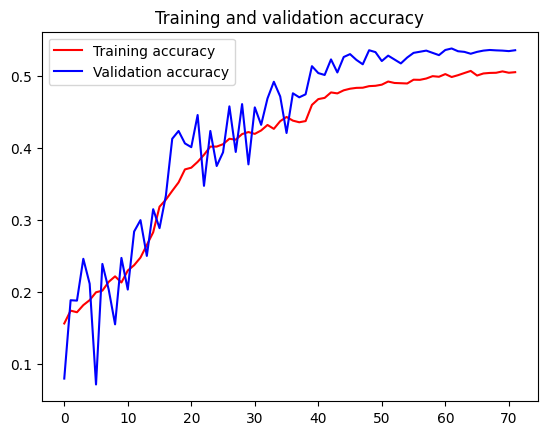

<Figure size 640x480 with 0 Axes>

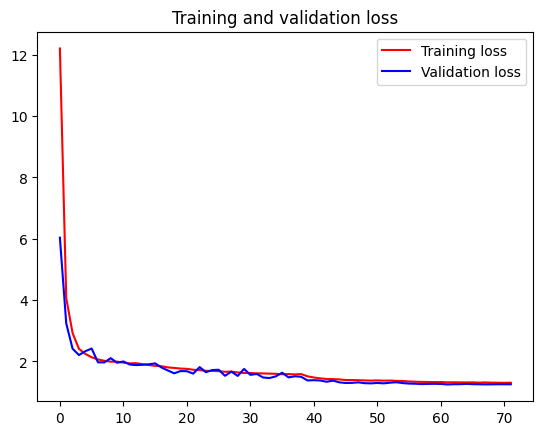

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest9_MoreData.history['accuracy']
val_acc = historytest9_MoreData.history['val_accuracy']
loss = historytest9_MoreData.history['loss']
val_loss = historytest9_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 9 CNN 52.74%

In [25]:
model10_MoreData = tf.keras.models.Sequential()   

model10_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model10_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model10_MoreData.add(BatchNormalization())
model10_MoreData.add(MaxPooling2D(2, 2))
model10_MoreData.add(Dropout(0.3))

model10_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model10_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model10_MoreData.add(BatchNormalization())
model10_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model10_MoreData.add(Dropout(0.3))

model10_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model10_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model10_MoreData.add(BatchNormalization())
model10_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model10_MoreData.add(Dropout(0.3))

model10_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model10_MoreData.add(Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model10_MoreData.add(BatchNormalization())
model10_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model10_MoreData.add(Dropout(0.3))

model10_MoreData.add(Flatten())
model10_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model10_MoreData.add(Dropout(0.5))
    
model10_MoreData.add(Dense(7, activation='softmax'))

model10_MoreData.compile(optimizer=Adam(learning_rate=1e-3), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [26]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test10_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test10_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test10_MoreData/64batch', exist_ok=True)



log_dir = "logs/test10_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [28]:
historytest10_MoreData = model10_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 11.9406 - accuracy: 0.1626
Epoch 1: val_accuracy improved from -inf to 0.16304, saving model to models/test10_MoreData/64batch\best_model_ModelPaper2_1_0.1630.h5
359/359 [==============================] - 33s 88ms/step - loss: 11.9406 - accuracy: 0.1626 - val_loss: 5.3189 - val_accuracy: 0.1630 - lr: 0.0010
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 3.6112 - accuracy: 0.1807
Epoch 2: val_accuracy did not improve from 0.16304
359/359 [==============================] - 30s 85ms/step - loss: 3.6112 - accuracy: 0.1807 - val_loss: 2.8434 - val_accuracy: 0.1092 - lr: 0.0010
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 2.4031 - accuracy: 0.1944
Epoch 3: val_accuracy improved from 0.16304 to 0.20293, saving model to models/test10_MoreData/64batch\best_model_ModelPaper2_3_0.2029.h5
359/359 [==============================] - 31s 85ms/step - loss: 2.4031 - accuracy: 0.1944 

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

#model10_MoreData = tf.keras.models.load_model(r'models/test5_MoreData/64batch\best_model_ModelPaper2_61_0.5307.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model10_MoreData.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 3s 29ms/step
              precision    recall  f1-score   support

           0       0.46      0.28      0.35       958
           1       0.16      0.78      0.26       111
           2       0.26      0.04      0.06      1024
           3       0.82      0.81      0.81      1774
           4       0.45      0.65      0.54      1233
           5       0.40      0.38      0.39      1247
           6       0.58      0.82      0.68       831

    accuracy                           0.53      7178
   macro avg       0.45      0.54      0.44      7178
weighted avg       0.52      0.53      0.50      7178

<function confusion_matrix at 0x0000019B8B8C9FC0>


In [31]:
model10_MoreData.evaluate(test_generator)

113/113 [==============================] - 4s 30ms/step - loss: 1.3011 - accuracy: 0.5274


[1.3010849952697754, 0.5274449586868286]

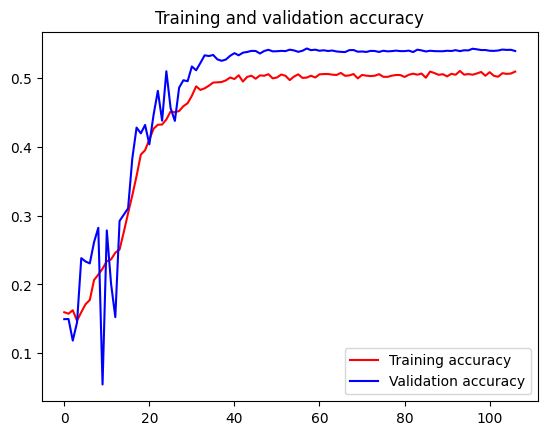

<Figure size 640x480 with 0 Axes>

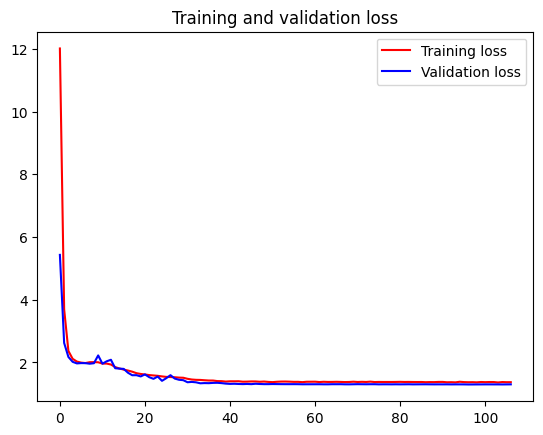

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest10_MoreData.history['accuracy']
val_acc = historytest10_MoreData.history['val_accuracy']
loss = historytest10_MoreData.history['loss']
val_loss = historytest10_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Other Data-Augmentation - CNN

### More Rotation_range 63.59% (another transformations 1 data-augmentation)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'


train_datagen2 = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=20, #The rotation change to rotation range between -20 to 20           
    horizontal_flip=True,   #Horizontal flip True
    vertical_flip=True,     #Vertical flip true
    validation_split=0.2          
)

val_datagen2 = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen2 = ImageDataGenerator(
    rescale=1/255
)

train_generator2 = train_datagen2.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='grayscale',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="training",              
    shuffle=True
)

val_generator2 = val_datagen2.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='grayscale',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="validation",            
    shuffle=False
)

test_generator2 = test_datagen2.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='grayscale',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator2.classes)

#Balancing training set
class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


#### Model with another transformations 1

In [ ]:
model8_MoreData2 = tf.keras.models.Sequential()   

model8_MoreData2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,1)))
model8_MoreData2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData2.add(BatchNormalization())
model8_MoreData2.add(MaxPooling2D(2, 2))
model8_MoreData2.add(Dropout(0.3))

model8_MoreData2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData2.add(BatchNormalization())
model8_MoreData2.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData2.add(Dropout(0.3))

model8_MoreData2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData2.add(BatchNormalization())
model8_MoreData2.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData2.add(Dropout(0.3))

model8_MoreData2.add(Flatten())
model8_MoreData2.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData2.add(Dropout(0.5))
    
model8_MoreData2.add(Dense(7, activation='softmax'))

model8_MoreData2.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData2_otherImageGenerator/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData2_otherImageGenerator/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData2_otherImageGenerator/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData2_otherImageGenerator/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest8_MoreData2 = model8_MoreData2.fit(
    x = train_generator2,
    epochs = 300,
    validation_data = val_generator2, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 23.1925 - accuracy: 0.1700
Epoch 1: val_accuracy improved from -inf to 0.14301, saving model to models/test8_MoreData2_otherImageGenerator/64batch\best_model_ModelPaper2_1_0.1430.h5
359/359 [==============================] - 31s 82ms/step - loss: 23.1925 - accuracy: 0.1700 - val_loss: 21.3216 - val_accuracy: 0.1430 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 18.9990 - accuracy: 0.1834
Epoch 2: val_accuracy improved from 0.14301 to 0.25553, saving model to models/test8_MoreData2_otherImageGenerator/64batch\best_model_ModelPaper2_2_0.2555.h5
359/359 [==============================] - 29s 81ms/step - loss: 18.9990 - accuracy: 0.1834 - val_loss: 17.0335 - val_accuracy: 0.2555 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 15.2933 - accuracy: 0.2041
Epoch 3: val_accuracy did not improve from 0.25553
359/359 [=============================

In [ ]:
model8_MoreData2.evaluate(test_generator2)

113/113 [==============================] - 8s 71ms/step - loss: 1.2452 - accuracy: 0.6360


[1.2452232837677002, 0.6359710097312927]

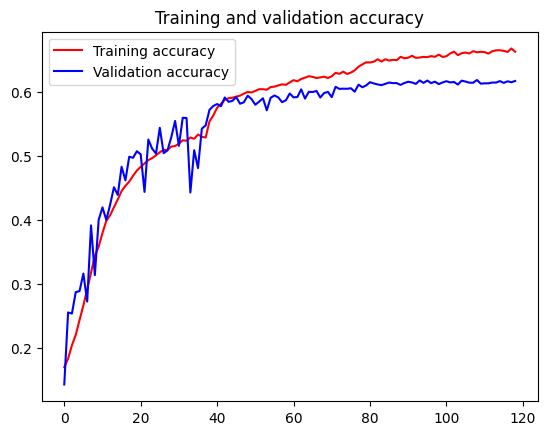

<Figure size 640x480 with 0 Axes>

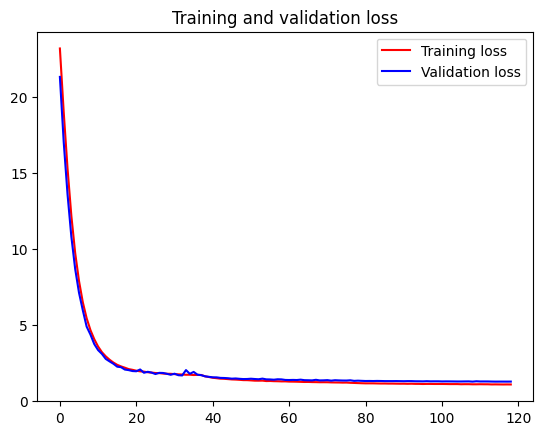

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest8_MoreData2.history['accuracy']
val_acc = historytest8_MoreData2.history['val_accuracy']
loss = historytest8_MoreData2.history['loss']
val_loss = historytest8_MoreData2.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

### More Hiperparameters 64.58% (another transformation 2 data-augmentation)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'


train_datagen3 = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=25,   #Change rotation range between -25 and 25        
    zoom_range=0.2,               
    width_shift_range=0.2,     #biggest change of 0.1 to 0.2   
    height_shift_range=0.2,    #biggest change of 0.1 to 0.2   
    horizontal_flip=True,         
    fill_mode='nearest',          
    validation_split=0.2          
)

val_datagen3 = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen3 = ImageDataGenerator(
    rescale=1/255
)


train_generator3 = train_datagen3.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="training",              
    shuffle=True
)

val_generator3 = val_datagen3.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="validation",            
    shuffle=False
)

test_generator3 = test_datagen3.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator3.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


#### Model with another transformations 2

In [ ]:
model8_MoreData3 = tf.keras.models.Sequential()   

model8_MoreData3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData3.add(BatchNormalization())
model8_MoreData3.add(MaxPooling2D(2, 2))
model8_MoreData3.add(Dropout(0.3))

model8_MoreData3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData3.add(BatchNormalization())
model8_MoreData3.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData3.add(Dropout(0.3))

model8_MoreData3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData3.add(BatchNormalization())
model8_MoreData3.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData3.add(Dropout(0.3))

model8_MoreData3.add(Flatten())
model8_MoreData3.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData3.add(Dropout(0.5))
    
model8_MoreData3.add(Dense(7, activation='softmax'))

model8_MoreData3.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData3_otherImageGenerator3/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData3_otherImageGenerator3/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData3_otherImageGenerator3/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData3_otherImageGenerator3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest8_MoreData3 = model8_MoreData3.fit(
    x = train_generator3,
    epochs = 300,
    validation_data = val_generator3, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 23.4614 - accuracy: 0.1594
Epoch 1: val_accuracy improved from -inf to 0.01533, saving model to models/test8_MoreData3_otherImageGenerator3/64batch\best_model_ModelPaper2_1_0.0153.h5
359/359 [==============================] - 47s 125ms/step - loss: 23.4614 - accuracy: 0.1594 - val_loss: 23.4568 - val_accuracy: 0.0153 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 19.3927 - accuracy: 0.1739
Epoch 2: val_accuracy improved from 0.01533 to 0.17001, saving model to models/test8_MoreData3_otherImageGenerator3/64batch\best_model_ModelPaper2_2_0.1700.h5
359/359 [==============================] - 43s 121ms/step - loss: 19.3927 - accuracy: 0.1739 - val_loss: 17.5866 - val_accuracy: 0.1700 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 15.7711 - accuracy: 0.1795
Epoch 3: val_accuracy improved from 0.17001 to 0.24595, saving model to models/test8_

In [ ]:
model8_MoreData3.evaluate(test_generator3)

113/113 [==============================] - 8s 74ms/step - loss: 1.1630 - accuracy: 0.6459


[1.1629613637924194, 0.645862340927124]

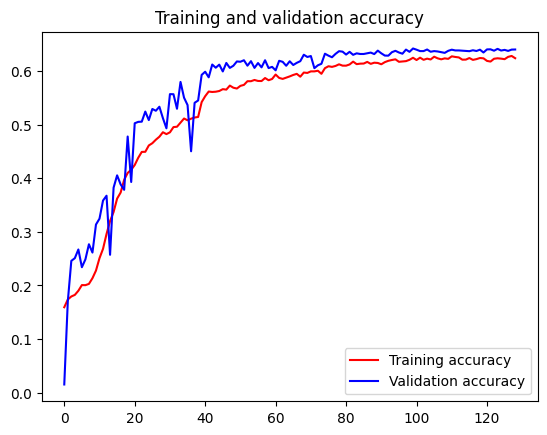

<Figure size 640x480 with 0 Axes>

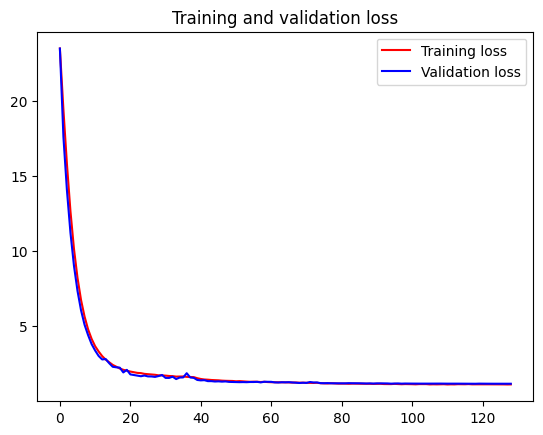

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest8_MoreData3.history['accuracy']
val_acc = historytest8_MoreData3.history['val_accuracy']
loss = historytest8_MoreData3.history['loss']
val_loss = historytest8_MoreData3.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

### Not vertical_flip 66.45% (another transformation 3 data-augmenation)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'

train_datagen4 = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=20,            
    horizontal_flip=True,         #Vertical flip removed
    validation_split=0.2          
)

val_datagen4 = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen4 = ImageDataGenerator(
    rescale=1/255
)

train_generator4 = train_datagen4.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="training",              
    shuffle=True
)

val_generator4 = val_datagen4.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="validation",            
    shuffle=False
)

test_generator4 = test_datagen4.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator4.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))


print("Class Weights Dictionary:", class_weights_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


#### Model with another transformations 3

In [ ]:
model8_MoreData4 = tf.keras.models.Sequential()   

model8_MoreData4.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData4.add(BatchNormalization())
model8_MoreData4.add(MaxPooling2D(2, 2))
model8_MoreData4.add(Dropout(0.3))

model8_MoreData4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData4.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData4.add(BatchNormalization())
model8_MoreData4.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData4.add(Dropout(0.3))

model8_MoreData4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData4.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData4.add(BatchNormalization())
model8_MoreData4.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData4.add(Dropout(0.3))

model8_MoreData4.add(Flatten())
model8_MoreData4.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData4.add(Dropout(0.5))
    
model8_MoreData4.add(Dense(7, activation='softmax'))

model8_MoreData4.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData4_otherImageGenerator4/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData4_otherImageGenerator4/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData4_otherImageGenerator4/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData4_otherImageGenerator4/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest8_MoreData4 = model8_MoreData4.fit(
    x = train_generator4,
    epochs = 300,
    validation_data = val_generator4, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 23.2706 - accuracy: 0.1807
Epoch 1: val_accuracy improved from -inf to 0.25118, saving model to models/test8_MoreData4_otherImageGenerator4/64batch\best_model_ModelPaper2_1_0.2512.h5
359/359 [==============================] - 44s 117ms/step - loss: 23.2706 - accuracy: 0.1807 - val_loss: 23.4309 - val_accuracy: 0.2512 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 19.1097 - accuracy: 0.2103
Epoch 2: val_accuracy improved from 0.25118 to 0.27417, saving model to models/test8_MoreData4_otherImageGenerator4/64batch\best_model_ModelPaper2_2_0.2742.h5
359/359 [==============================] - 42s 116ms/step - loss: 19.1097 - accuracy: 0.2103 - val_loss: 17.3361 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 15.4929 - accuracy: 0.2334
Epoch 3: val_accuracy improved from 0.27417 to 0.29838, saving model to models/test8_

In [ ]:
model8_MoreData4.evaluate(test_generator3)

113/113 [==============================] - 13s 111ms/step - loss: 1.2324 - accuracy: 0.6659


[1.2324317693710327, 0.6659236550331116]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData8_load = tf.keras.models.load_model(r'models\test8_MoreData4_otherImageGenerator4\64batch\best_model_ModelPaper2_103_0.6588.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model_moreData8_load.predict(test_generator).argmax(axis=1) 

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       958
           1       0.63      0.59      0.61       111
           2       0.54      0.42      0.47      1024
           3       0.88      0.85      0.86      1774
           4       0.58      0.71      0.64      1233
           5       0.56      0.51      0.53      1247
           6       0.74      0.84      0.78       831

    accuracy                           0.67      7178
   macro avg       0.64      0.64      0.64      7178
weighted avg       0.66      0.67      0.66      7178

<function confusion_matrix at 0x000001870AF1AEF0>


In [29]:
model_moreData8_load.evaluate(test_generator)

113/113 [==============================] - 5s 39ms/step - loss: 1.2369 - accuracy: 0.6656


[1.2369061708450317, 0.6656450033187866]

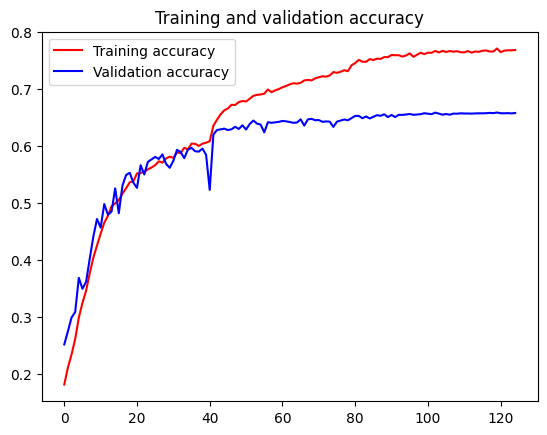

<Figure size 640x480 with 0 Axes>

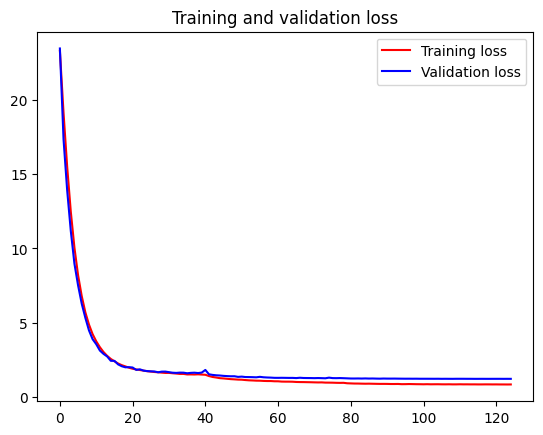

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest8_MoreData4.history['accuracy']
val_acc = historytest8_MoreData4.history['val_accuracy']
loss = historytest8_MoreData4.history['loss']
val_loss = historytest8_MoreData4.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 11 CNN 65.50%

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.regularizers import l2

model_new = Sequential()

model_new.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model_new.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_new.add(BatchNormalization())
model_new.add(MaxPooling2D(pool_size=(2, 2)))
model_new.add(Dropout(0.25))

model_new.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(BatchNormalization())
model_new.add(MaxPooling2D(pool_size=(2, 2)))
model_new.add(Dropout(0.25))

model_new.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(BatchNormalization())
model_new.add(MaxPooling2D(pool_size=(2, 2)))
model_new.add(Dropout(0.25))

model_new.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(BatchNormalization())
model_new.add(MaxPooling2D(pool_size=(2, 2)))
model_new.add(Dropout(0.25))

model_new.add(GlobalAveragePooling2D())

model_new.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model_new.add(Dropout(0.5))

model_new.add(Dense(7, activation='softmax'))

model_new.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

model_new.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_23 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test12_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test12_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test12_MoreData/64batch', exist_ok=True)



log_dir = "logs/test12_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new = model_new.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 4.7836 - accuracy: 0.1647
Epoch 1: val_accuracy improved from -inf to 0.01707, saving model to models/test12_MoreData/64batch\best_model_ModelPaper2_1_0.0171.h5
359/359 [==============================] - 45s 122ms/step - loss: 4.7836 - accuracy: 0.1647 - val_loss: 4.6281 - val_accuracy: 0.0171 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 4.3176 - accuracy: 0.1753
Epoch 2: val_accuracy improved from 0.01707 to 0.12158, saving model to models/test12_MoreData/64batch\best_model_ModelPaper2_2_0.1216.h5
359/359 [==============================] - 43s 121ms/step - loss: 4.3176 - accuracy: 0.1753 - val_loss: 4.1467 - val_accuracy: 0.1216 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 3.9794 - accuracy: 0.1956
Epoch 3: val_accuracy improved from 0.12158 to 0.17819, saving model to models/test12_MoreData/64batch\best_model_ModelPaper2_3_0.1782

In [ ]:
model_new.evaluate(test_generator)

113/113 [==============================] - 10s 86ms/step - loss: 1.2812 - accuracy: 0.6503


[1.281203031539917, 0.6503204107284546]

In [28]:
model_new_load = tf.keras.models.load_model('models/test12_MoreData/best_model_ModelPaper2_58_0.6473.h5')
model_new_load.evaluate(test_generator)

113/113 [==============================] - 10s 82ms/step - loss: 1.2827 - accuracy: 0.6551


[1.2826836109161377, 0.6550571322441101]

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model_new_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 40ms/step
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       958
           1       0.60      0.64      0.62       111
           2       0.53      0.42      0.47      1024
           3       0.89      0.84      0.86      1774
           4       0.57      0.69      0.62      1233
           5       0.54      0.49      0.51      1247
           6       0.74      0.81      0.77       831

    accuracy                           0.66      7178
   macro avg       0.63      0.64      0.63      7178
weighted avg       0.66      0.66      0.65      7178

<function confusion_matrix at 0x000002188B849F30>


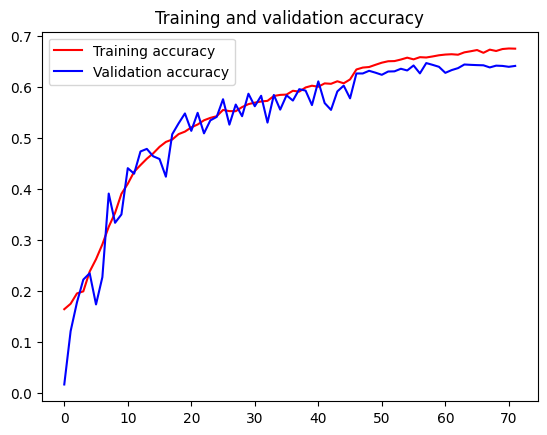

<Figure size 640x480 with 0 Axes>

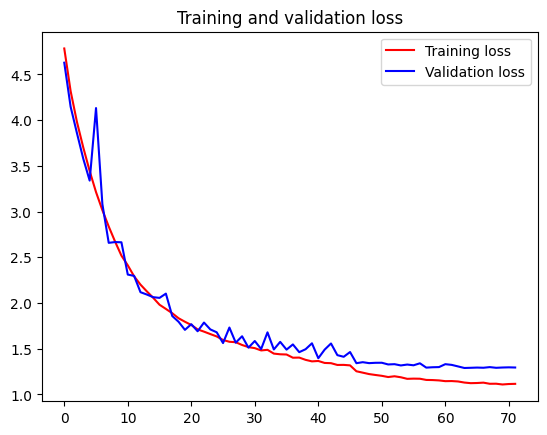

In [ ]:
import matplotlib.pyplot as plt
accuracy = historymodel_new.history['accuracy']
val_acc = historymodel_new.history['val_accuracy']
loss = historymodel_new.history['loss']
val_loss = historymodel_new.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 12 CNN 65.82%

In [ ]:
model13 = tf.keras.models.Sequential()

model13.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model13.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(2, 2))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Flatten())
model13.add(Dense(2048, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))
model13.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))

model13.add(Dense(7, activation='softmax'))

model13.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test13_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test13_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test13_MoreData/64batch', exist_ok=True)



log_dir = "logs/test13_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new13 = model13.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 45.4580 - accuracy: 0.1648
Epoch 1: val_accuracy improved from -inf to 0.17279, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_1_0.1728.h5
359/359 [==============================] - 47s 126ms/step - loss: 45.4580 - accuracy: 0.1648 - val_loss: 40.5393 - val_accuracy: 0.1728 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 35.8313 - accuracy: 0.1715
Epoch 2: val_accuracy improved from 0.17279 to 0.24665, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_2_0.2466.h5
359/359 [==============================] - 44s 121ms/step - loss: 35.8313 - accuracy: 0.1715 - val_loss: 31.2111 - val_accuracy: 0.2466 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 27.3132 - accuracy: 0.1892
Epoch 3: val_accuracy improved from 0.24665 to 0.26267, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_3

113/113 [==============================] - 12s 107ms/step - loss: 1.1889 - accuracy: 0.6583
[1.1888659000396729, 0.6582613587379456]


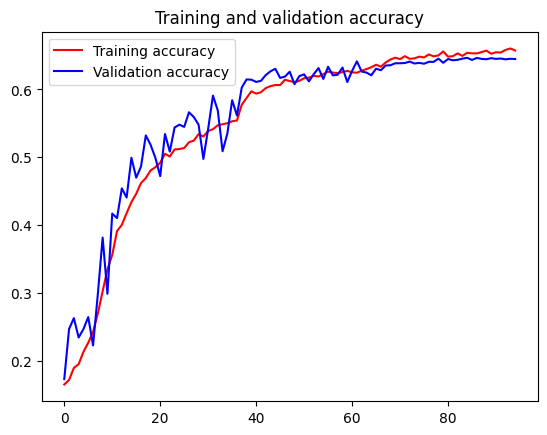

<Figure size 640x480 with 0 Axes>

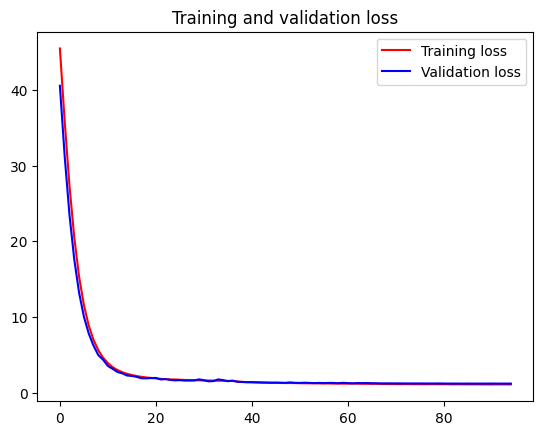

In [ ]:
print(model13.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new13.history['accuracy']
val_acc = historymodel_new13.history['val_accuracy']
loss = historymodel_new13.history['loss']
val_loss = historymodel_new13.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [32]:
model13_load_model = tf.keras.models.load_model('models/test13_ModeData1dataset/best_model_ModelPaper2_85_0.6466.h5')
model13_load_model.evaluate(test_generator)

113/113 [==============================] - 5s 41ms/step - loss: 1.1889 - accuracy: 0.6583


[1.1888659000396729, 0.6582613587379456]

In [33]:
y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model13_load_model.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.57      0.60      0.58       958
           1       0.59      0.64      0.61       111
           2       0.51      0.42      0.46      1024
           3       0.89      0.83      0.86      1774
           4       0.58      0.70      0.63      1233
           5       0.56      0.51      0.53      1247
           6       0.72      0.82      0.77       831

    accuracy                           0.66      7178
   macro avg       0.63      0.64      0.64      7178
weighted avg       0.66      0.66      0.66      7178

<function confusion_matrix at 0x000002188B849F30>


## Model 13 CNN 63.80%

In [ ]:
model14 = tf.keras.models.Sequential()

model14.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model14.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(2, 2))
model14.add(Dropout(0.3))

model14.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model14.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model14.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(pool_size=(2, 2)))
model14.add(Dropout(0.3))

model14.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model14.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model14.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(pool_size=(2, 2)))
model14.add(Dropout(0.3))

model14.add(Flatten())
model14.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model14.add(Dropout(0.5))

model14.add(Dense(7, activation='softmax'))

model14.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test14_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test14_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test14_MoreData/64batch', exist_ok=True)



log_dir = "logs/test14_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new14 = model14.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 25.5448 - accuracy: 0.1695
Epoch 1: val_accuracy improved from -inf to 0.17453, saving model to models/test14_MoreData/64batch\best_model_ModelPaper2_1_0.1745.h5
359/359 [==============================] - 46s 124ms/step - loss: 25.5448 - accuracy: 0.1695 - val_loss: 23.5219 - val_accuracy: 0.1745 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 20.9644 - accuracy: 0.1817
Epoch 2: val_accuracy improved from 0.17453 to 0.22818, saving model to models/test14_MoreData/64batch\best_model_ModelPaper2_2_0.2282.h5
359/359 [==============================] - 44s 123ms/step - loss: 20.9644 - accuracy: 0.1817 - val_loss: 18.8783 - val_accuracy: 0.2282 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 17.0672 - accuracy: 0.1937
Epoch 3: val_accuracy did not improve from 0.22818
359/359 [==============================] - 44s 123ms/step - loss: 17.0672 - 

113/113 [==============================] - 5s 42ms/step - loss: 1.2383 - accuracy: 0.6397
[1.238294005393982, 0.6397325396537781]


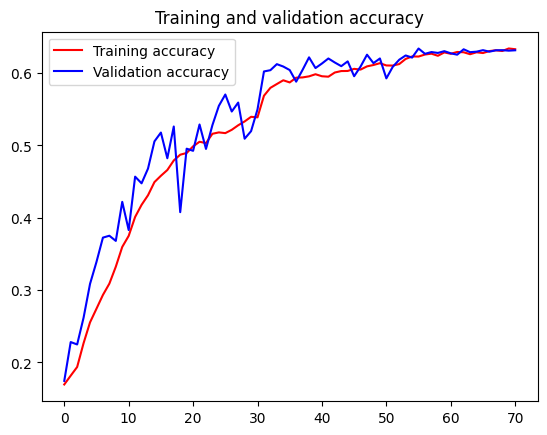

<Figure size 640x480 with 0 Axes>

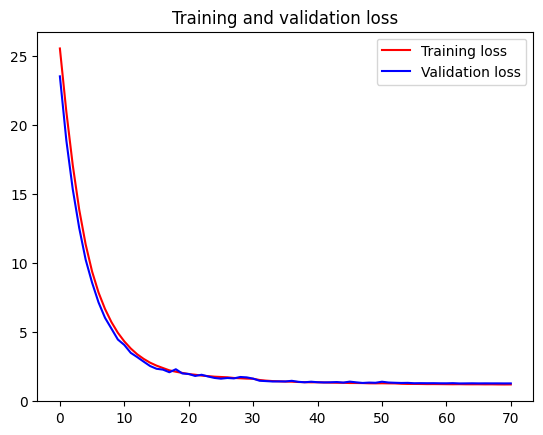

In [ ]:
print(model14.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new14.history['accuracy']
val_acc = historymodel_new14.history['val_accuracy']
loss = historymodel_new14.history['loss']
val_loss = historymodel_new14.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [34]:
model14_load_model = tf.keras.models.load_model('models/test14_MoreData/best_model_ModelPaper2_56_0.6340.h5')
model14_load_model.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.2554 - accuracy: 0.6381


[1.2554172277450562, 0.6380607485771179]

In [35]:
y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model14_load_model.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 41ms/step
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       958
           1       0.41      0.72      0.52       111
           2       0.49      0.36      0.42      1024
           3       0.88      0.84      0.86      1774
           4       0.55      0.69      0.61      1233
           5       0.55      0.44      0.49      1247
           6       0.68      0.83      0.75       831

    accuracy                           0.64      7178
   macro avg       0.59      0.64      0.60      7178
weighted avg       0.64      0.64      0.63      7178

<function confusion_matrix at 0x000002188B849F30>


## Model 14 CNN 64.40%

In [ ]:
model15 = Sequential()

model15.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model15.add(BatchNormalization())
model15.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Flatten())
model15.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
model15.add(Dropout(0.5))
model15.add(Dense(7, activation='softmax'))

model15.compile(optimizer=Adam(learning_rate=1e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model15.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_14 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test15_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test15_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test15_MoreData/64batch', exist_ok=True)



log_dir = "logs/test15_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new15 = model15.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 17.5825 - accuracy: 0.1654
Epoch 1: val_accuracy improved from -inf to 0.18464, saving model to models/test15_MoreData/64batch\best_model_ModelPaper2_1_0.1846.h5
359/359 [==============================] - 59s 143ms/step - loss: 17.5825 - accuracy: 0.1654 - val_loss: 15.3793 - val_accuracy: 0.1846 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 13.4096 - accuracy: 0.1803
Epoch 2: val_accuracy improved from 0.18464 to 0.24090, saving model to models/test15_MoreData/64batch\best_model_ModelPaper2_2_0.2409.h5
359/359 [==============================] - 49s 136ms/step - loss: 13.4096 - accuracy: 0.1803 - val_loss: 11.6079 - val_accuracy: 0.2409 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 9.9643 - accuracy: 0.1938
Epoch 3: val_accuracy did not improve from 0.24090
359/359 [==============================] - 49s 135ms/step - loss: 9.9643 - ac

113/113 [==============================] - 8s 72ms/step - loss: 1.0261 - accuracy: 0.6414
[1.0261285305023193, 0.6414042711257935]


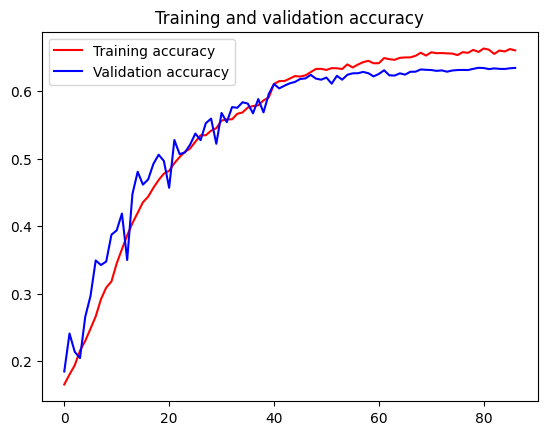

<Figure size 640x480 with 0 Axes>

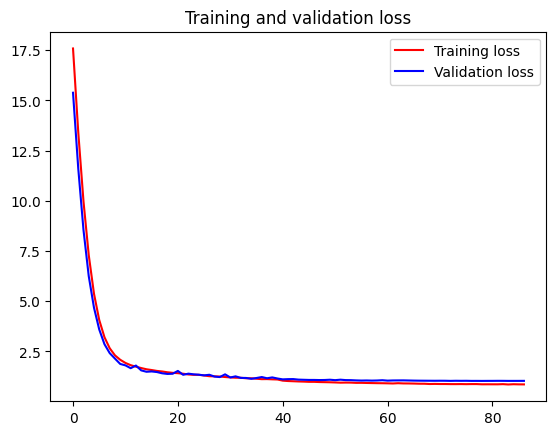

In [ ]:
print(model15.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new15.history['accuracy']
val_acc = historymodel_new15.history['val_accuracy']
loss = historymodel_new15.history['loss']
val_loss = historymodel_new15.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [36]:
model15_load_model = tf.keras.models.load_model('models/test15_MoreData/best_model_ModelPaper2_80_0.6344.h5')
model15_load_model.evaluate(test_generator)

113/113 [==============================] - 5s 44ms/step - loss: 1.0271 - accuracy: 0.6441


[1.0271077156066895, 0.6440512537956238]

In [37]:
y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model15_load_model.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 43ms/step
              precision    recall  f1-score   support

           0       0.55      0.63      0.59       958
           1       0.44      0.68      0.53       111
           2       0.56      0.34      0.42      1024
           3       0.88      0.83      0.85      1774
           4       0.53      0.71      0.61      1233
           5       0.56      0.45      0.50      1247
           6       0.71      0.83      0.76       831

    accuracy                           0.64      7178
   macro avg       0.60      0.64      0.61      7178
weighted avg       0.65      0.64      0.64      7178

<function confusion_matrix at 0x000002188B849F30>


## Model 15 CNN 51.75%

In [ ]:
from keras.layers import concatenate

def inception_module(x, filters):
    path1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    path2 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(path2)

    path3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(path3)

    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters, (1, 1), padding='same', activation='relu')(path4)

    return concatenate([path1, path2, path3, path4], axis=-1)

input_layer = Input(shape=(48, 48, 3))
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = inception_module(x, 32)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = inception_module(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = inception_module(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

model16 = Model(inputs=input_layer, outputs=output_layer)

model16.compile(optimizer=Adam(learning_rate=1e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_38 (Conv2D)             (None, 48, 48, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 48, 48, 64)  256         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_18 (MaxPooling2D  (None, 24, 24, 64)  0           ['batch_normalization_22[0][0

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test16_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test16_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test16_MoreData/64batch', exist_ok=True)



log_dir = "logs/test16_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new16 = model16.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)


Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 14.1743 - accuracy: 0.1576
Epoch 1: val_accuracy improved from -inf to 0.21704, saving model to models/test16_MoreData/64batch\best_model_ModelPaper2_1_0.2170.h5
359/359 [==============================] - 45s 120ms/step - loss: 14.1743 - accuracy: 0.1576 - val_loss: 10.5153 - val_accuracy: 0.2170 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 8.5047 - accuracy: 0.1724
Epoch 2: val_accuracy did not improve from 0.21704
359/359 [==============================] - 42s 117ms/step - loss: 8.5047 - accuracy: 0.1724 - val_loss: 6.8673 - val_accuracy: 0.1482 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 5.7520 - accuracy: 0.1771
Epoch 3: val_accuracy improved from 0.21704 to 0.23515, saving model to models/test16_MoreData/64batch\best_model_ModelPaper2_3_0.2352.h5
359/359 [==============================] - 42s 118ms/step - loss: 5.7520 - accur

113/113 [==============================] - 5s 41ms/step - loss: 1.3449 - accuracy: 0.5176
[1.3448723554611206, 0.5175536274909973]


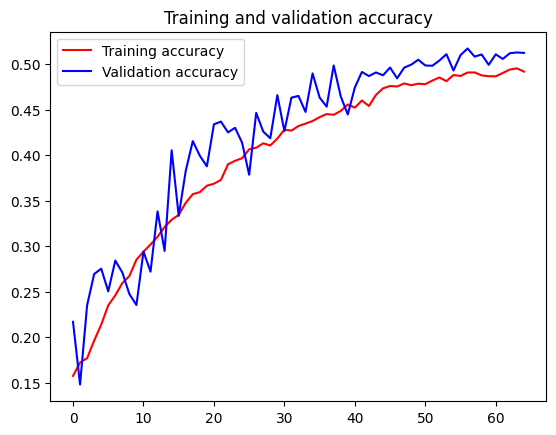

<Figure size 640x480 with 0 Axes>

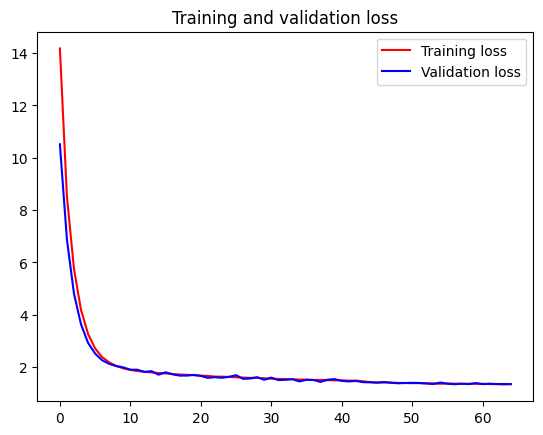

In [ ]:
print(model16.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new16.history['accuracy']
val_acc = historymodel_new16.history['val_accuracy']
loss = historymodel_new16.history['loss']
val_loss = historymodel_new16.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [39]:
model16_load_model = tf.keras.models.load_model('models/test16_MoreData/best_model_ModelPaper2_57_0.5172.h5')
model16_load_model.evaluate(test_generator)

113/113 [==============================] - 5s 39ms/step - loss: 1.3449 - accuracy: 0.5176


[1.3448723554611206, 0.5175536274909973]

In [40]:
y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model16_load_model.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.45      0.39      0.42       958
           1       0.16      0.66      0.25       111
           2       0.36      0.22      0.27      1024
           3       0.81      0.72      0.76      1774
           4       0.44      0.61      0.51      1233
           5       0.52      0.26      0.35      1247
           6       0.52      0.83      0.64       831

    accuracy                           0.52      7178
   macro avg       0.46      0.53      0.46      7178
weighted avg       0.54      0.52      0.51      7178

<function confusion_matrix at 0x000002188B849F30>


## Model 16 - MiniXceptionNet 24.81%

In [ ]:
from keras import layers
from keras.layers import Activation, Convolution2D, Conv2D, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Input, MaxPooling2D, SeparableConv2D
from keras.models import Model
from keras.regularizers import L2

l2_regularization = 0.01
regularization = L2(l2_regularization)


image_input = Input((48,48,3))


x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(image_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x= Dropout(0.25)(x)


residual = Conv2D(filters=16, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x= Dropout(0.25)(x)


x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])
x= Dropout(0.25)(x)


residual = Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x= Dropout(0.25)(x)

x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])
x= Dropout(0.25)(x)

residual = Conv2D(filters=64, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x= Dropout(0.25)(x)

x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])
x= Dropout(0.25)(x)

residual = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x= Dropout(0.25)(x)

x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])
x= Dropout(0.25)(x)

x = Conv2D(filters=7, kernel_size=(3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
x= Dropout(0.5)(x)

output = Activation('softmax', name='predictions')(x)


modelMini = Model(image_input, output)
modelMini.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
modelMini.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_57 (Conv2D)             (None, 46, 46, 8)    216         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_23 (BatchN  (None, 46, 46, 8)   32          ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation (Activation)        (None, 46, 46, 8)    0           ['batch_normalization_23[0]

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test17_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test17_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test17_MoreData/64batch', exist_ok=True)



log_dir = "logs/test17_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new17 = modelMini.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 2.2996 - accuracy: 0.1425
Epoch 1: val_accuracy improved from -inf to 0.25187, saving model to models/test17_MoreData/64batch\best_model_ModelPaper2_1_0.2519.h5
359/359 [==============================] - 42s 109ms/step - loss: 2.2996 - accuracy: 0.1425 - val_loss: 1.9998 - val_accuracy: 0.2519 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 2.2168 - accuracy: 0.1479
Epoch 2: val_accuracy did not improve from 0.25187
359/359 [==============================] - 37s 103ms/step - loss: 2.2168 - accuracy: 0.1479 - val_loss: 2.1371 - val_accuracy: 0.0667 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 2.2003 - accuracy: 0.1480
Epoch 3: val_accuracy did not improve from 0.25187
359/359 [==============================] - 37s 104ms/step - loss: 2.2003 - accuracy: 0.1480 - val_loss: 2.1143 - val_accuracy: 0.0549 - lr: 1.0000e-04
Epoch 4/200
359/359

113/113 [==============================] - 5s 43ms/step - loss: 2.0028 - accuracy: 0.2481
[2.0028414726257324, 0.24811924993991852]


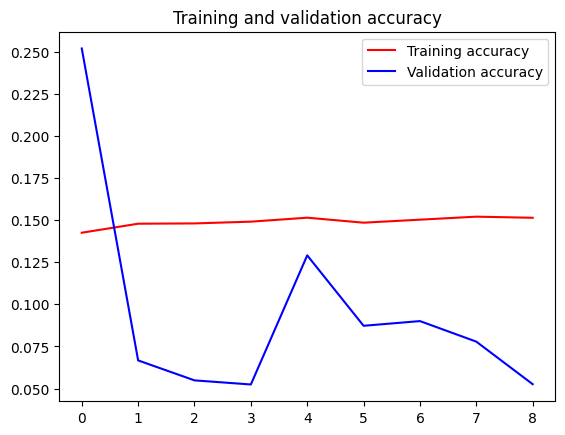

<Figure size 640x480 with 0 Axes>

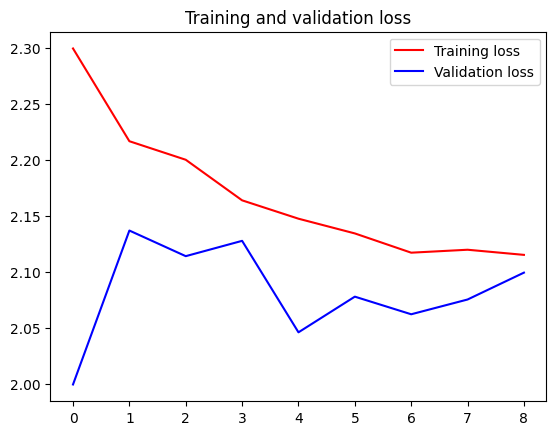

In [ ]:
print(modelMini.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new17.history['accuracy']
val_acc = historymodel_new17.history['val_accuracy']
loss = historymodel_new17.history['loss']
val_loss = historymodel_new17.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 17 XceptionNet 60.04%

In [ ]:
from keras.applications import Xception
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Resizing, Input
from tensorflow.keras.optimizers import Adam
from keras.regularizers import L2 


base_modelXception = Xception(weights= "imagenet", input_shape=(75,75,3), include_top=False)

for layer in base_modelXception.layers[:-10]:
  layer.trainable = False

input= Input(shape=(48,48,3))
input_resize = Resizing(75,75)(input) #Because the XceptionNet model requires inputs of size 75x75

x = base_modelXception(input_resize)
x = Dropout(0.50)(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)
x = GlobalAveragePooling2D()(x)

x = Dense(2048, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)

modelXception = Model(inputs = input, outputs = predictions)

modelXception.compile(loss="categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])

modelXception.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 75, 75, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 dropout_39 (Dropout)        (None, 3, 3, 2048)        0         
                                                                 
 batch_normalization_41 (Bat  (None, 3, 3, 2048)       8192      
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 3, 3, 2048)        0         
                                                           

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test18_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test18_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test18_MoreData/64batch', exist_ok=True)



log_dir = "logs/test18_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new18 = modelXception.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 3.8699 - accuracy: 0.2684
Epoch 1: val_accuracy improved from -inf to 0.41125, saving model to models/test18_MoreData/64batch\best_model_ModelPaper2_1_0.4113.h5
359/359 [==============================] - 56s 140ms/step - loss: 3.8699 - accuracy: 0.2684 - val_loss: 3.5143 - val_accuracy: 0.4113 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 3.5495 - accuracy: 0.3514
Epoch 2: val_accuracy improved from 0.41125 to 0.44226, saving model to models/test18_MoreData/64batch\best_model_ModelPaper2_2_0.4423.h5
359/359 [==============================] - 47s 131ms/step - loss: 3.5495 - accuracy: 0.3514 - val_loss: 3.3121 - val_accuracy: 0.4423 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 3.3347 - accuracy: 0.3878
Epoch 3: val_accuracy improved from 0.44226 to 0.45706, saving model to models/test18_MoreData/64batch\best_model_ModelPaper2_3_0.4571

In [19]:
modelXception_load = tf.keras.models.load_model(r'models\OtherModels\XceptionNet/best_model_ModelPaper2_54_0.5964.h5')
evaluate = modelXception_load.evaluate(test_generator)
print(evaluate)

predict = modelXception_load.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predict, axis=-1)

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)

113/113 [==============================] - 7s 48ms/step - loss: 1.3546 - accuracy: 0.6004
[1.3546204566955566, 0.6004458069801331]
113/113 [==============================] - 6s 44ms/step
              precision    recall  f1-score   support

           0       0.49      0.52      0.50       958
           1       0.70      0.59      0.64       111
           2       0.49      0.42      0.45      1024
           3       0.79      0.78      0.78      1774
           4       0.51      0.62      0.56      1233
           5       0.53      0.40      0.46      1247
           6       0.67      0.80      0.73       831

    accuracy                           0.60      7178
   macro avg       0.60      0.59      0.59      7178
weighted avg       0.60      0.60      0.60      7178

[[ 499   10  108   75  128   95   43]
 [  23   65    4    9    5    5    0]
 [ 118    5  427   61  134  145  134]
 [  75    2   52 1380  146   62   57]
 [  98    2   85  103  770  125   50]
 [ 184    7  137   96  275

113/113 [==============================] - 9s 81ms/step - loss: 1.3546 - accuracy: 0.6004
[1.3546204566955566, 0.6004458069801331]


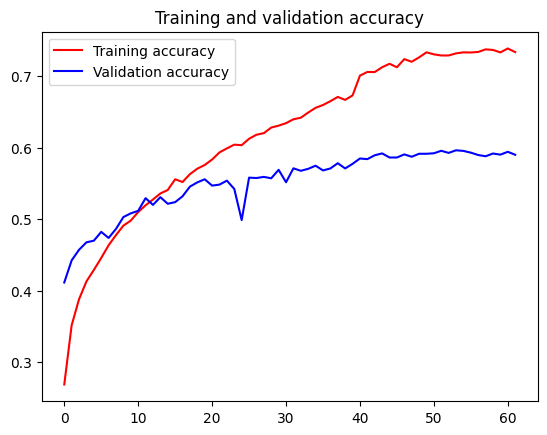

<Figure size 640x480 with 0 Axes>

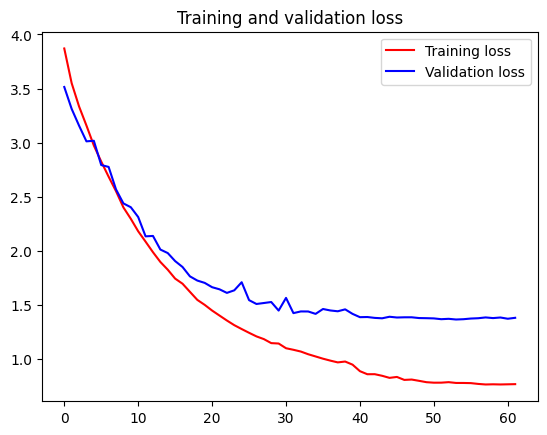

In [ ]:
print(modelXception.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new18.history['accuracy']
val_acc = historymodel_new18.history['val_accuracy']
loss = historymodel_new18.history['loss']
val_loss = historymodel_new18.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 18 CNN 52.28%

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

model20 = Sequential()

model20.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model20.add(BatchNormalization())
model20.add(MaxPooling2D(pool_size=(2, 2)))
model20.add(Dropout(0.25))

model20.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model20.add(BatchNormalization())
model20.add(MaxPooling2D(pool_size=(2, 2)))
model20.add(Dropout(0.25))

model20.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model20.add(BatchNormalization())
model20.add(MaxPooling2D(pool_size=(2, 2)))
model20.add(Dropout(0.25))

model20.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model20.add(BatchNormalization())
model20.add(MaxPooling2D(pool_size=(2, 2)))
model20.add(Dropout(0.25))

model20.add(Flatten())
model20.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model20.add(Dropout(0.5))
model20.add(Dense(7, activation='softmax'))

model20.compile(optimizer=Adam(learning_rate=1e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model20.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_47 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_74 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_48 (Bat  (None, 24, 24, 64)      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test20_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test20_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test20_MoreData/64batch', exist_ok=True)



log_dir = "logs/test20_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new20 = model20.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 10.2926 - accuracy: 0.1602
Epoch 1: val_accuracy improved from -inf to 0.05905, saving model to models/test20_MoreData/64batch\best_model_ModelPaper2_1_0.0590.h5
359/359 [==============================] - 62s 168ms/step - loss: 10.2926 - accuracy: 0.1602 - val_loss: 10.0446 - val_accuracy: 0.0590 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 8.5992 - accuracy: 0.1796
Epoch 2: val_accuracy improved from 0.05905 to 0.14196, saving model to models/test20_MoreData/64batch\best_model_ModelPaper2_2_0.1420.h5
359/359 [==============================] - 41s 113ms/step - loss: 8.5992 - accuracy: 0.1796 - val_loss: 8.0520 - val_accuracy: 0.1420 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 7.2472 - accuracy: 0.1887
Epoch 3: val_accuracy improved from 0.14196 to 0.18499, saving model to models/test20_MoreData/64batch\best_model_ModelPaper2_3_0.1

113/113 [==============================] - 10s 85ms/step - loss: 1.3177 - accuracy: 0.5208
[1.3177154064178467, 0.5207578539848328]


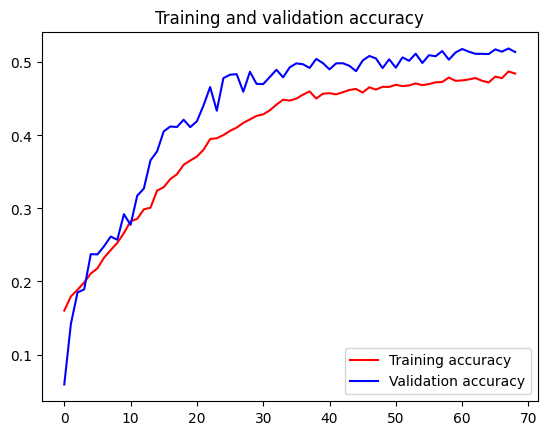

<Figure size 640x480 with 0 Axes>

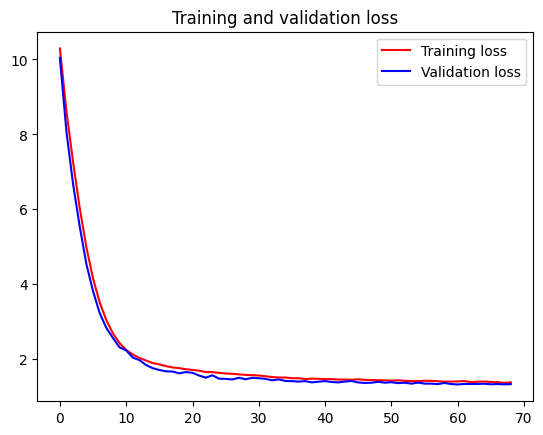

In [ ]:
print(model20.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new20.history['accuracy']
val_acc = historymodel_new20.history['val_accuracy']
loss = historymodel_new20.history['loss']
val_loss = historymodel_new20.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [41]:
model20_load_model = tf.keras.models.load_model('models/test20_MoreData/best_model_ModelPaper2_68_0.5189.h5')
model20_load_model.evaluate(test_generator)

113/113 [==============================] - 5s 39ms/step - loss: 1.3172 - accuracy: 0.5228


[1.3171677589416504, 0.522847592830658]

In [42]:
y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model20_load_model.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 36ms/step
              precision    recall  f1-score   support

           0       0.38      0.57      0.45       958
           1       0.16      0.64      0.26       111
           2       0.36      0.18      0.24      1024
           3       0.84      0.72      0.77      1774
           4       0.51      0.49      0.50      1233
           5       0.48      0.32      0.39      1247
           6       0.54      0.80      0.65       831

    accuracy                           0.52      7178
   macro avg       0.47      0.53      0.47      7178
weighted avg       0.55      0.52      0.52      7178

<function confusion_matrix at 0x000002188B849F30>


## Model 19 MobileNet 59.50%

In [ ]:
from keras.applications import MobileNet

MobileNet = tf.keras.applications.MobileNet(input_shape=(48, 48, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

MobileNet.summary()

MobileNet.trainable = True

for layer in MobileNet.layers[:-50]:
    layer.trainable = False

def Create_MobileNet_Model():

    model = Sequential([
                      MobileNet,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

MobileNet_Model = Create_MobileNet_Model()

MobileNet_Model.summary()

MobileNet_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                         

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test21_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test21_MoreData/64batch/best_model_ModelPaper2_{epoch}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test21_MoreData/64batch', exist_ok=True)



log_dir = "logs/test21_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

In [47]:
historymodel_new21 = MobileNet_Model.fit(
    x = train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs = 200,
    validation_data = val_generator, 
    validation_steps=validation_steps,
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
358/358 [==============================] - ETA: 0s - loss: 2.2484 - accuracy: 0.2225
Epoch 1: val_accuracy improved from -inf to 0.34077, saving model to models/test21_MoreData/64batch\best_model_ModelPaper2_1.h5
358/358 [==============================] - 43s 114ms/step - loss: 2.2484 - accuracy: 0.2225 - val_loss: 1.7282 - val_accuracy: 0.3408 - lr: 0.0010
Epoch 2/200
358/358 [==============================] - ETA: 0s - loss: 1.7481 - accuracy: 0.3369
Epoch 2: val_accuracy improved from 0.34077 to 0.38869, saving model to models/test21_MoreData/64batch\best_model_ModelPaper2_2.h5
358/358 [==============================] - 40s 111ms/step - loss: 1.7481 - accuracy: 0.3369 - val_loss: 1.5811 - val_accuracy: 0.3887 - lr: 0.0010
Epoch 3/200
358/358 [==============================] - ETA: 0s - loss: 1.5912 - accuracy: 0.3847
Epoch 3: val_accuracy improved from 0.38869 to 0.41854, saving model to models/test21_MoreData/64batch\best_model_ModelPaper2_3.h5
358/358 [================

In [20]:
modelMobileNet_load = tf.keras.models.load_model(r'models\OtherModels\MobileNet/best_model_ModelPaper2_40.h5')
evaluate = modelMobileNet_load.evaluate(test_generator)
print(evaluate)

predict = modelMobileNet_load.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predict, axis=-1)

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)

113/113 [==============================] - 5s 37ms/step - loss: 1.1065 - accuracy: 0.5950
[1.1064692735671997, 0.5950125455856323]
113/113 [==============================] - 5s 35ms/step
              precision    recall  f1-score   support

           0       0.47      0.58      0.52       958
           1       0.42      0.63      0.50       111
           2       0.49      0.38      0.42      1024
           3       0.86      0.74      0.80      1774
           4       0.50      0.65      0.57      1233
           5       0.53      0.40      0.45      1247
           6       0.67      0.78      0.72       831

    accuracy                           0.60      7178
   macro avg       0.56      0.59      0.57      7178
weighted avg       0.61      0.60      0.59      7178

[[ 552   26   80   38  126  103   33]
 [  24   70    3    1    7    3    3]
 [ 162   17  386   23  166  147  123]
 [ 118   21   39 1314  171   52   59]
 [ 108    8   62   69  801  129   56]
 [ 180   23  153   59  294

113/113 [==============================] - 9s 78ms/step - loss: 1.0977 - accuracy: 0.6032
[1.0977210998535156, 0.6032320857048035]


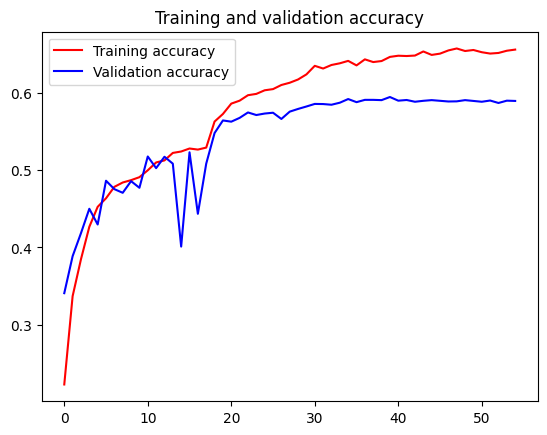

<Figure size 640x480 with 0 Axes>

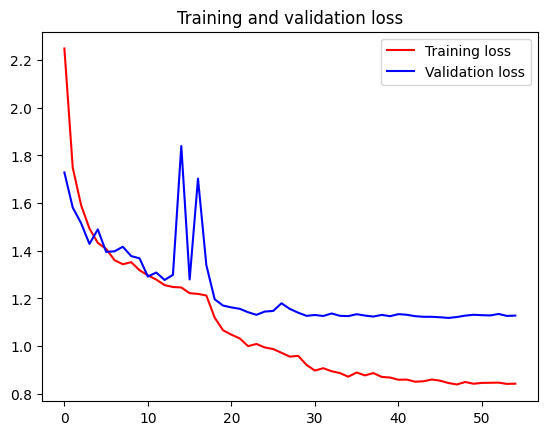

In [48]:
print(MobileNet_Model.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new21.history['accuracy']
val_acc = historymodel_new21.history['val_accuracy']
loss = historymodel_new21.history['loss']
val_loss = historymodel_new21.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 20 CNN 57.30%

In [64]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import tensorflow as tf 

model22 = Sequential()

model22.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,3)))
model22.add(BatchNormalization())
model22.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(MaxPooling2D(pool_size=(2, 2)))
model22.add(Dropout(0.25))

model22.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(MaxPooling2D(pool_size=(2, 2)))
model22.add(Dropout(0.25))

model22.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(MaxPooling2D(pool_size=(2, 2)))
model22.add(Dropout(0.25))

model22.add(Flatten())
model22.add(Dense(256, activation='relu'))
model22.add(BatchNormalization())
model22.add(Dropout(0.5))
model22.add(Dense(128, activation='relu')) # thapeko
model22.add(Dense(7, activation='softmax'))

model22.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])

c:\Users\bryan\anaconda3\envs\GPU_IEMOCAP\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [65]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test22_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test22_MoreData/64batch/best_model_ModelPaper2_{epoch}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test22_MoreData/64batch', exist_ok=True)



log_dir = "logs/test22_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [66]:
historymodel_new22 = model22.fit(
    x = train_generator,
    steps_per_epoch=len(train_generator),
    epochs = 200,
    validation_data = val_generator, 
    validation_steps=len(val_generator),
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 2.0908 - accuracy: 0.1533
Epoch 1: val_accuracy improved from -inf to 0.15154, saving model to models/test22_MoreData/64batch\best_model_ModelPaper2_1.h5
359/359 [==============================] - 48s 126ms/step - loss: 2.0908 - accuracy: 0.1533 - val_loss: 1.9694 - val_accuracy: 0.1515 - lr: 0.0100
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 1.9321 - accuracy: 0.1686
Epoch 2: val_accuracy improved from 0.15154 to 0.17662, saving model to models/test22_MoreData/64batch\best_model_ModelPaper2_2.h5
359/359 [==============================] - 41s 114ms/step - loss: 1.9321 - accuracy: 0.1686 - val_loss: 1.9189 - val_accuracy: 0.1766 - lr: 0.0100
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 1.8998 - accuracy: 0.1931
Epoch 3: val_accuracy improved from 0.17662 to 0.19962, saving model to models/test22_MoreData/64batch\best_model_ModelPaper2_3.h5
359/359 [================

113/113 [==============================] - 12s 103ms/step - loss: 1.1227 - accuracy: 0.5741
[1.122687816619873, 0.5741153359413147]


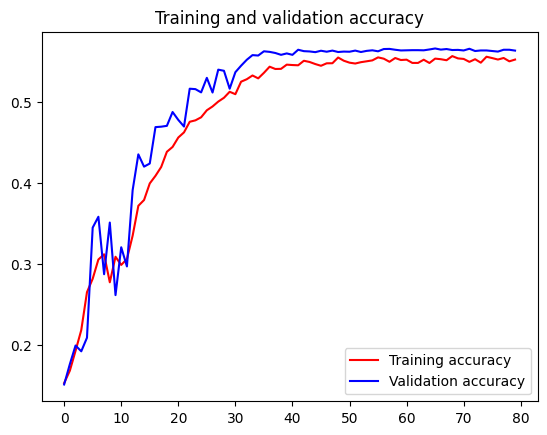

<Figure size 640x480 with 0 Axes>

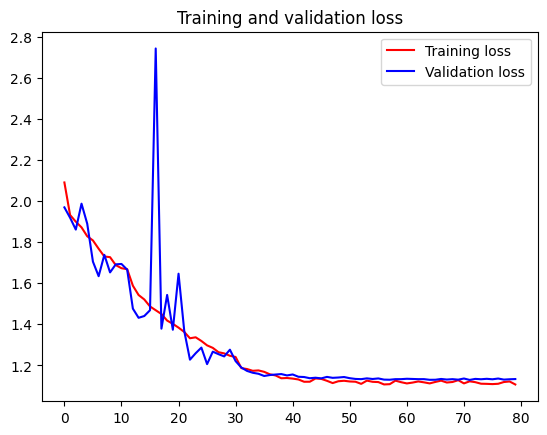

In [67]:
print(model22.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new22.history['accuracy']
val_acc = historymodel_new22.history['val_accuracy']
loss = historymodel_new22.history['loss']
val_loss = historymodel_new22.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [43]:
model22_load_model = tf.keras.models.load_model('models/test22_MoreData/best_model_ModelPaper2_66.h5')
model22_load_model.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.1234 - accuracy: 0.5730


[1.1233948469161987, 0.5730008482933044]

In [44]:
y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model22_load_model.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 35ms/step
              precision    recall  f1-score   support

           0       0.47      0.49      0.48       958
           1       0.24      0.71      0.36       111
           2       0.35      0.16      0.22      1024
           3       0.88      0.77      0.82      1774
           4       0.50      0.68      0.58      1233
           5       0.46      0.42      0.44      1247
           6       0.64      0.82      0.72       831

    accuracy                           0.57      7178
   macro avg       0.51      0.58      0.52      7178
weighted avg       0.58      0.57      0.56      7178

<function confusion_matrix at 0x000002188B849F30>


## Model 21 Keras Tunner 66.94%

In [ ]:
def build_model(hp):
    input_layer = tf.keras.layers.Input(shape=(48, 48, 3))
    x = input_layer
    
    num_layers = hp.Int('num_layers', min_value=2, max_value=6)
    for i in range(num_layers): #for each layer
        num_filters1 = hp.Int(f'conv_{i}_units1', min_value=32, max_value=512, step=32) #Creates a hidden layer that has between 32 to 512 filters
        x = tf.keras.layers.Conv2D(filters=num_filters1, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x) #With ReLU and padding = same
        num_filters2 = hp.Int(f'conv_{i}_units2', min_value=32, max_value=512, step=32) #Creates a hidden layer that has between 32 to 512 filters
        x = tf.keras.layers.Conv2D(filters=num_filters2, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x) #With ReLU and padding = same
        x = BatchNormalization()(x)
        
        # Conditional verification for MaxPooling2D
        if x.shape[1] > 1 and x.shape[2] > 1:
            x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x) #search the optimal learning rate

    x = tf.keras.layers.Flatten()(x)
    x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(7, activation="softmax")(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model



In [ ]:
tuner = kt.BayesianOptimization( #Configuration by Bayesian optimization for all possibilities.
    build_model,
    objective='val_accuracy',
    max_trials=6,  # Max number of tests .
    executions_per_trial=3,
    directory='TunerBayesianDirectory',
    project_name='KerasTuner'
)

In [49]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
tuner.search( #Search by Bayesian optimization for all possibilities.
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Trial 6 Complete [03h 47m 13s]
val_accuracy: 0.6558090845743815

Best val_accuracy So Far: 0.6612669229507446
Total elapsed time: 18h 11m 53s


In [ ]:
print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

model = tuner.get_best_models(num_models=1)[0] #Get the best model found in the tests
print (model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 288)       166176    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 288)      1152      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 288)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 288)       0     

Creation the keras tunner model 1

In [11]:
input = tf.keras.layers.Input(shape=(48,48,3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(input)
x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(224, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

#x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
#x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
#x = BatchNormalization()(x)
#x = MaxPooling2D(2,2)(x)
#x = Dropout(0.4)(x)


x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation="softmax")(x)

modelTunner = tf.keras.models.Model(inputs=input, outputs=output_layer)

modelTunner.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

modelTunner.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_41 (Conv2D)          (None, 48, 48, 288)       166176    
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 288)      1152      
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 288)      0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 288)       0   

In [12]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelKerasTunner/64batch', exist_ok=True)


checkpoint_path = 'models/ModelKerasTunner/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelKerasTunner/64batch', exist_ok=True)



log_dir = "logs/ModelKerasTunner/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [13]:
HistoryTunner = modelTunner.fit(
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 27.0807 - accuracy: 0.1572
Epoch 1: val_accuracy improved from -inf to 0.18742, saving model to models/ModelKerasTunner/64batch\best_model_ModelPaper2_1_0.1874.h5
359/359 [==============================] - 85s 210ms/step - loss: 27.0807 - accuracy: 0.1572 - val_loss: 25.1658 - val_accuracy: 0.1874 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 23.3976 - accuracy: 0.1684
Epoch 2: val_accuracy improved from 0.18742 to 0.19753, saving model to models/ModelKerasTunner/64batch\best_model_ModelPaper2_2_0.1975.h5
359/359 [==============================] - 58s 161ms/step - loss: 23.3976 - accuracy: 0.1684 - val_loss: 22.1033 - val_accuracy: 0.1975 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 20.2524 - accuracy: 0.1761
Epoch 3: val_accuracy improved from 0.19753 to 0.24909, saving model to models/ModelKerasTunner/64batch\best_model_ModelPaper

In [21]:
modelKerasTunner_load = tf.keras.models.load_model(r'models\OtherModels\Keras Tunner/best_model_ModelPaper2_114_0.6581.h5')
evaluate = modelKerasTunner_load.evaluate(test_generator)
print(evaluate)

predict = modelKerasTunner_load.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predict, axis=-1)

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)

113/113 [==============================] - 7s 51ms/step - loss: 1.1732 - accuracy: 0.6694
[1.173243761062622, 0.669406533241272]
113/113 [==============================] - 5s 45ms/step
              precision    recall  f1-score   support

           0       0.55      0.65      0.60       958
           1       0.64      0.67      0.65       111
           2       0.58      0.42      0.49      1024
           3       0.89      0.84      0.87      1774
           4       0.58      0.71      0.64      1233
           5       0.58      0.50      0.54      1247
           6       0.73      0.83      0.78       831

    accuracy                           0.67      7178
   macro avg       0.65      0.66      0.65      7178
weighted avg       0.67      0.67      0.67      7178

[[ 620   23   62   25  114   94   20]
 [  25   74    1    2    3    3    3]
 [ 143    7  429   19  128  176  122]
 [  52    2   26 1496  114   27   57]
 [  84    2   46   68  872  135   26]
 [ 162    6  120   45  265  

113/113 [==============================] - 26s 228ms/step - loss: 1.1732 - accuracy: 0.6694
[1.173243761062622, 0.669406533241272]


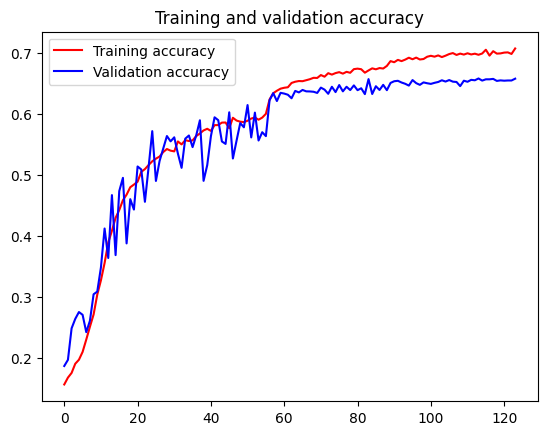

<Figure size 640x480 with 0 Axes>

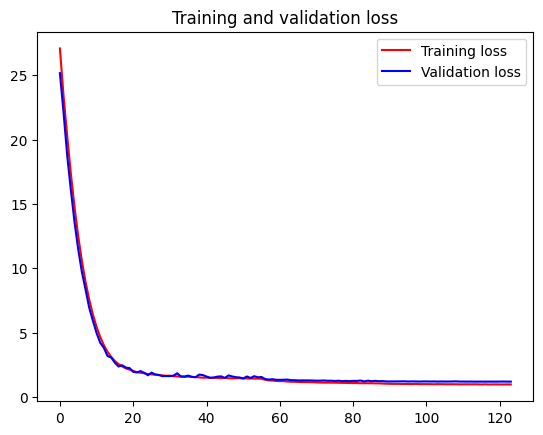

In [14]:
print(modelTunner.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = HistoryTunner.history['accuracy']
val_acc = HistoryTunner.history['val_accuracy']
loss = HistoryTunner.history['loss']
val_loss = HistoryTunner.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

Creation the keras tunner model 2

In [15]:
input = tf.keras.layers.Input(shape=(48,48,3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(input)
x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(224, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)


x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation="softmax")(x)

modelTunner2 = tf.keras.models.Model(inputs=input, outputs=output_layer)

modelTunner2.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

modelTunner2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_49 (Conv2D)          (None, 48, 48, 288)       166176    
                                                                 
 batch_normalization_24 (Bat  (None, 48, 48, 288)      1152      
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 288)      0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 24, 24, 288)       0   

In [16]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelKerasTunner2/64batch', exist_ok=True)


checkpoint_path = 'models/ModelKerasTunner2/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelKerasTunner2/64batch', exist_ok=True)



log_dir = "logs/ModelKerasTunner2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
HistoryTunner2 = modelTunner2.fit(
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 17.5461 - accuracy: 0.1562
Epoch 1: val_accuracy improved from -inf to 0.23306, saving model to models/ModelKerasTunner2/64batch\best_model_ModelPaper2_1_0.2331.h5
359/359 [==============================] - 62s 167ms/step - loss: 17.5461 - accuracy: 0.1562 - val_loss: 16.4878 - val_accuracy: 0.2331 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 15.7284 - accuracy: 0.1609
Epoch 2: val_accuracy did not improve from 0.23306
359/359 [==============================] - 59s 165ms/step - loss: 15.7284 - accuracy: 0.1609 - val_loss: 14.8925 - val_accuracy: 0.0406 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 14.0736 - accuracy: 0.1701
Epoch 3: val_accuracy did not improve from 0.23306
359/359 [==============================] - 58s 162ms/step - loss: 14.0736 - accuracy: 0.1701 - val_loss: 13.2442 - val_accuracy: 0.1980 - lr: 1.0000e-04
Epoch 4/

113/113 [==============================] - 5s 47ms/step - loss: 1.2093 - accuracy: 0.6585
[1.2093474864959717, 0.6585400104522705]


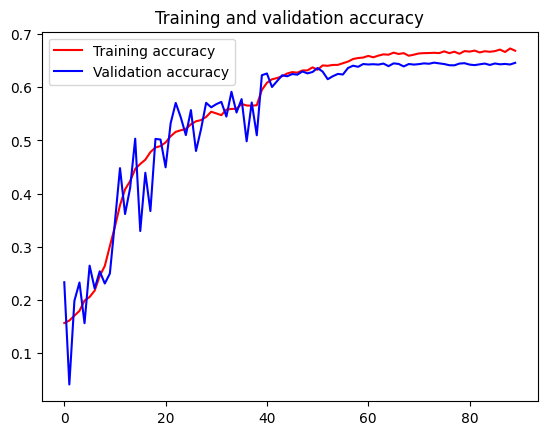

<Figure size 640x480 with 0 Axes>

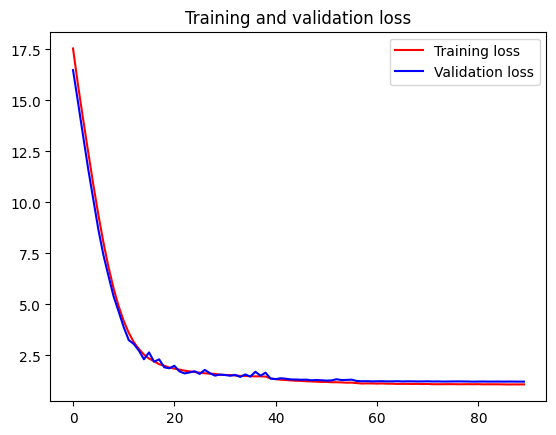

In [18]:
print(modelTunner2.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = HistoryTunner2.history['accuracy']
val_acc = HistoryTunner2.history['val_accuracy']
loss = HistoryTunner2.history['loss']
val_loss = HistoryTunner2.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

# -- With 2 datasets (FER2013 and CK+48) --

In [ ]:
train_dir_FER2013 = 'fer2013/train'
dataset_CK48 = 'CK+48/CK+48'

## Moving the images of FER2013 and CK+48 to concatenated FER and CK+48

In [ ]:
os.makedirs('concatenatedFERandCK', exist_ok=True) # Created destination folder

labelscorrects = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise", "anger", "sadness"]

listFilesFER = os.listdir(train_dir_FER2013)
for label in tqdm(listFilesFER): #to each label in the directory FER2013 (train)
    print("Label FER2013: ", label)
    pathlabel = os.path.join(train_dir_FER2013, label)
    listlabels = os.listdir(pathlabel)
    direction = os.path.join('concatenatedFERandCK', label)
    os.makedirs(direction, exist_ok=True)
    for fileinlabel in listlabels: #to each image in FER2013 (train)
        filepath = os.path.join(pathlabel,fileinlabel)
        shutil.copy(filepath, direction) #Copy the images in the destination folder

listFilesCK = os.listdir(dataset_CK48) 
for label in tqdm(listFilesCK):  #to each label in the directory CK+48
    print("Label CK: ", label)
    pathlabel = os.path.join(dataset_CK48, label)
    listlabels = os.listdir(pathlabel)
    if label in labelscorrects: # If the label is correct
        if label=="anger": # the label can be anger
            direction = os.path.join('concatenatedFERandCK', 'angry')
        elif label=="sadness": # the label can be anger
            direction = os.path.join('concatenatedFERandCK', 'sad')
        else:
            direction = os.path.join('concatenatedFERandCK', label)
        print("LABEL CK+ SI TOMADO", label)
        os.makedirs(direction, exist_ok=True)
        for fileinlabel in listlabels: #to each image in FER2013 (train)
            filepath = os.path.join(pathlabel,fileinlabel)
            shutil.copy(filepath, direction) #Copy the images in the destination folder
    else:
        pass


  0%|          | 0/7 [00:00<?, ?it/s]

Label FER2013:  angry


 14%|█▍        | 1/7 [00:05<00:32,  5.35s/it]

Label FER2013:  disgust


 29%|██▊       | 2/7 [00:05<00:12,  2.57s/it]

Label FER2013:  fear


 43%|████▎     | 3/7 [00:12<00:16,  4.23s/it]

Label FER2013:  happy


 57%|█████▋    | 4/7 [00:23<00:20,  6.96s/it]

Label FER2013:  neutral


 71%|███████▏  | 5/7 [00:31<00:14,  7.31s/it]

Label FER2013:  sad


 86%|████████▌ | 6/7 [00:38<00:07,  7.34s/it]

Label FER2013:  surprise


  0%|          | 0/7 [00:00<?, ?it/s]

Label CK:  anger
LABEL CK+ SI TOMADO anger


 14%|█▍        | 1/7 [00:00<00:01,  5.39it/s]

Label CK:  contempt
Label CK:  disgust
LABEL CK+ SI TOMADO disgust


 43%|████▎     | 3/7 [00:00<00:00,  7.05it/s]

Label CK:  fear
LABEL CK+ SI TOMADO fear
Label CK:  happy
LABEL CK+ SI TOMADO happy


 86%|████████▌ | 6/7 [00:00<00:00,  6.19it/s]

Label CK:  sadness
LABEL CK+ SI TOMADO sadness
Label CK:  surprise
LABEL CK+ SI TOMADO surprise


100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


In [ ]:
train_concatenated = 'concatenatedFERandCK'
train_base = 'fer2013/train'

def count_images_byClass(directory): #to count the images of the base train versus the concatenated train to compare them
    classes = sorted(os.listdir(directory))
    num_images = []
    for clase in classes:
        class_dir = os.path.join(directory, clase)
        num_images.append(len(os.listdir(class_dir)))
    return classes, num_images

train_classes_concatenated, train_num_images_concatenated = count_images_byClass(train_concatenated)
train_classes, train_num_images = count_images_byClass(train_base)


print("Names of classes in concatenated train set: ", train_classes_concatenated)
print("Numbers by classes in concatenated train set", train_num_images_concatenated)

print("Names of classes in base train set: ", train_classes)
print("Numbers by classes in base train set", train_num_images)

Names of classes in concatenated train set:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Numbers by classes in concatenated train set [4130, 613, 4172, 7422, 4965, 4914, 3420]
Names of classes in base train set:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Numbers by classes in base train set [3995, 436, 4097, 7215, 4965, 4830, 3171]


In [14]:
train_num_images_concatenated_total = sum(train_num_images_concatenated)
train_num_images_total = sum(train_num_images)

print("Total images with concatenated datasets: ", train_num_images_concatenated_total)
print("Total images with base dataset (FER2013): ", train_num_images_total)

Total images with concatenated datasets:  29636
Total images with base dataset (FER2013):  28709


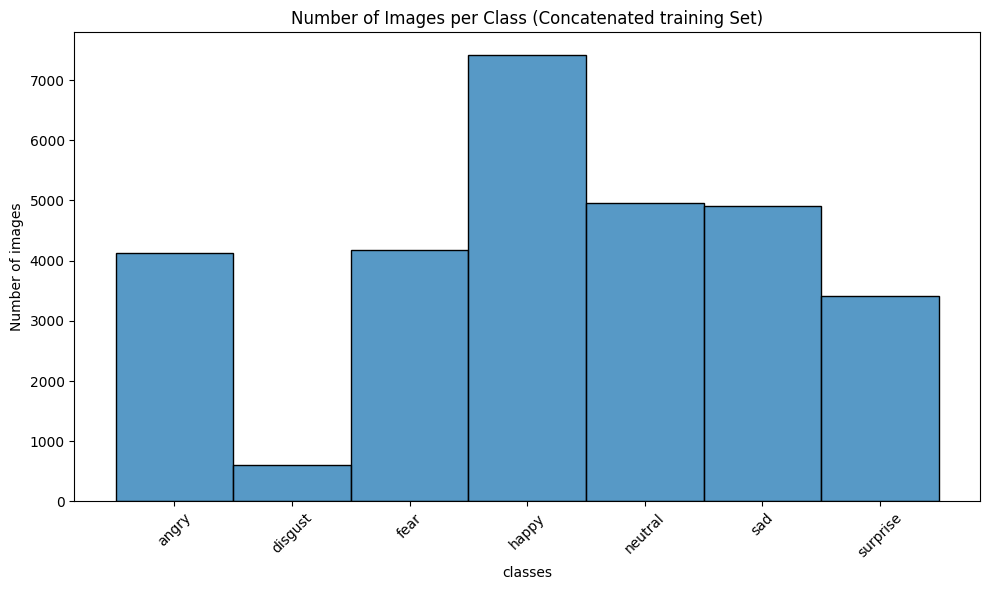

In [ ]:
plt.figure(figsize=(10, 6)) #Number of images on each class of the new train set
sns.histplot(x=train_classes_concatenated, weights=train_num_images_concatenated, bins=len(train_classes_concatenated), kde=False)
plt.xticks(rotation=45)
plt.xlabel('classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Concatenated training Set)')
plt.tight_layout()
plt.show()

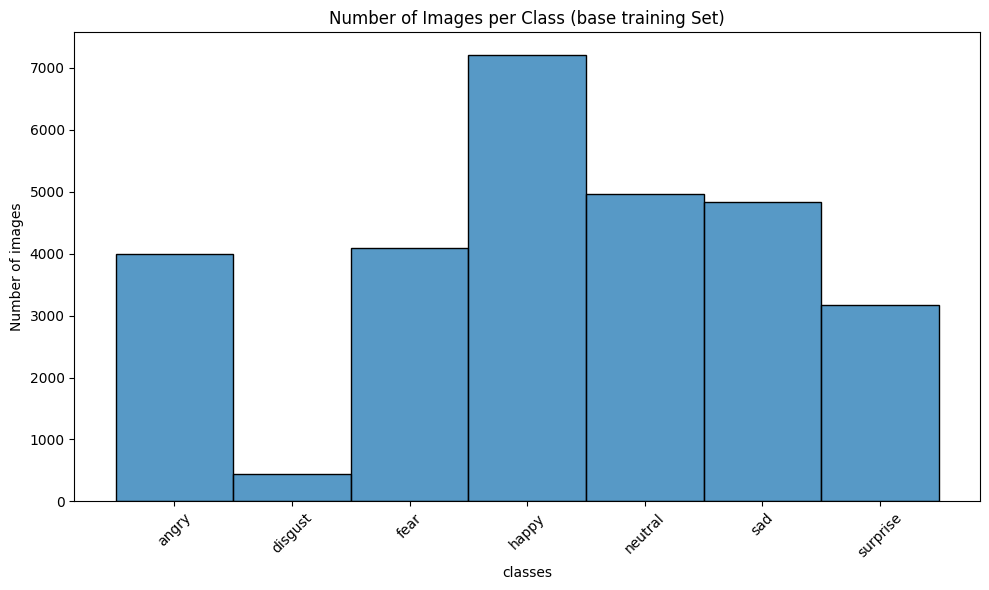

In [ ]:
plt.figure(figsize=(10, 6)) #Number of images on each class of the base train
sns.histplot(x=train_classes, weights=train_num_images, bins=len(train_classes), kde=False)
plt.xticks(rotation=45)
plt.xlabel('classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (base training Set)')
plt.tight_layout()
plt.show()

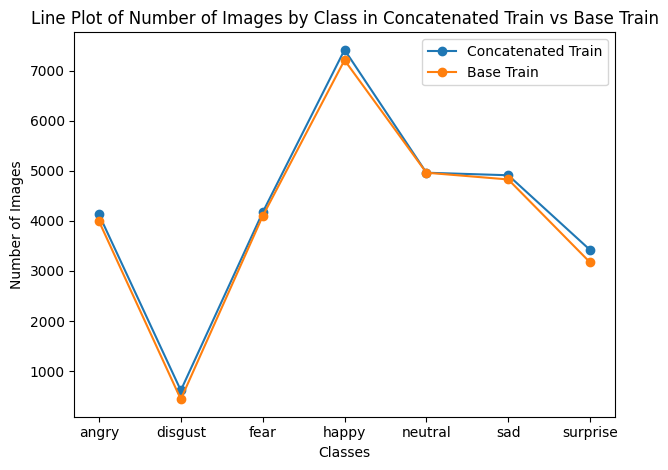

In [ ]:
fig, ax = plt.subplots() #Number of images on each class of the new train set
ax.plot(train_classes_concatenated, train_num_images_concatenated, label='Concatenated Train', marker='o')
ax.plot(train_classes, train_num_images, label='Base Train', marker='o')


ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Line Plot of Number of Images by Class in Concatenated Train vs Base Train')
ax.legend()

plt.xticks()
plt.tight_layout()
plt.show()

## Data augmentation and definition of importance by classes (balancing) in the train set

In [4]:
img_shape = 48

balancing by weighted weights

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir= 'concatenatedFERandCK' #new train set
test_dir = 'fer2013/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,           #Normalization     
    rotation_range=10,       #rotation range between -10 to 10     
    zoom_range=0.2,           #zoom range   
    width_shift_range=0.1,    # width shift range    
    height_shift_range=0.1,   # height shift range        
    horizontal_flip=True,     # horizontal flip in true    
    fill_mode='nearest',          
    validation_split=0.2      #train is divided into 20% for validation    
)

val_datagen = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),   #48x48     
    color_mode='rgb',          # transform to rgb images   
    class_mode='categorical',   # apply One Hot Encoder  
    batch_size=64,              # 64 batch   
    seed = 42,
    subset="training",          #Training set    
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),    #48x48   
    color_mode='rgb',             # transform to rgb images   
    class_mode='categorical',     # apply One Hot Encoder 
    batch_size=64,                # 64 batch 
    seed = 42,
    subset="validation",            #Validation set
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),      #48x48 
    color_mode='rgb',             # transform to rgb images
    class_mode='categorical',     # apply One Hot Encoder
    batch_size=64,                 # 64 batch
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator.classes)

# balancing by weighted weights 
class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 23711 images belonging to 7 classes.
Found 5925 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.025207540643376, 1: 6.898748908932208, 2: 1.0147650432251991, 3: 0.570442188326998, 4: 0.8527909653287297, 5: 0.8614663566342101, 6: 1.2380430242272347}


## Model 1 CNN 66.55%

In [ ]:
model_MoreData = tf.keras.Sequential([

        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,3)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_MoreData.compile(optimizer=optimiser, #The model is created
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_MoreData.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       2

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # to stop the model when it stops learning



#--------------------Checkpoint--------------------

os.makedirs('models/test1_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test1_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test1_MoreData/64batch', exist_ok=True)



log_dir = "logs/test1_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


training model

In [ ]:
historytest1_MoreData = model_MoreData.fit(x = train_generator,epochs = 300,validation_data = val_generator, class_weight=class_weights_dict, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 9.9715 - accuracy: 0.1624
Epoch 1: val_accuracy improved from -inf to 0.18160, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_1_0.1816.h5
371/371 [==============================] - 55s 122ms/step - loss: 9.9715 - accuracy: 0.1624 - val_loss: 9.4257 - val_accuracy: 0.1816 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 9.2236 - accuracy: 0.1752
Epoch 2: val_accuracy improved from 0.18160 to 0.19595, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_2_0.1959.h5
371/371 [==============================] - 45s 120ms/step - loss: 9.2236 - accuracy: 0.1752 - val_loss: 8.6765 - val_accuracy: 0.1959 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 8.5382 - accuracy: 0.1853
Epoch 3: val_accuracy improved from 0.19595 to 0.23882, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_3_0.2388.h5

In [ ]:
model_MoreData.evaluate(test_generator)

113/113 [==============================] - 25s 221ms/step - loss: 1.2571 - accuracy: 0.6655


[1.257135033607483, 0.6655057072639465]

In [ ]:
model_MoreData.save('models/test1_MoreData/64batch/best_model_ModelPaper2_122_0.6655.h5')

In [ ]:
model_MoreData_load = tf.keras.models.load_model(r'models\test1_MoreData\64batch\best_model_ModelPaper2_114_0.6675.h5')
model_MoreData_load.evaluate(test_generator)

113/113 [==============================] - 5s 41ms/step - loss: 1.2617 - accuracy: 0.6643


[1.2616521120071411, 0.6642518639564514]

In [8]:
model_MoreData_load = tf.keras.models.load_model(r'models/test1_MoreData/64batch/best_model_ModelPaper2_122_0.6655.h5')
model_MoreData_load.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.2571 - accuracy: 0.6655


[1.257135033607483, 0.6655057072639465]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Get all classes of y_test
y_pred = model_MoreData_load.predict(test_generator).argmax(axis=1) 

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 38ms/step
              precision    recall  f1-score   support

           0       0.56      0.64      0.59       958
           1       0.60      0.76      0.67       111
           2       0.57      0.40      0.47      1024
           3       0.91      0.84      0.87      1774
           4       0.56      0.72      0.63      1233
           5       0.57      0.49      0.53      1247
           6       0.75      0.82      0.78       831

    accuracy                           0.67      7178
   macro avg       0.64      0.67      0.65      7178
weighted avg       0.67      0.67      0.66      7178

<function confusion_matrix at 0x000001D18BC96050>


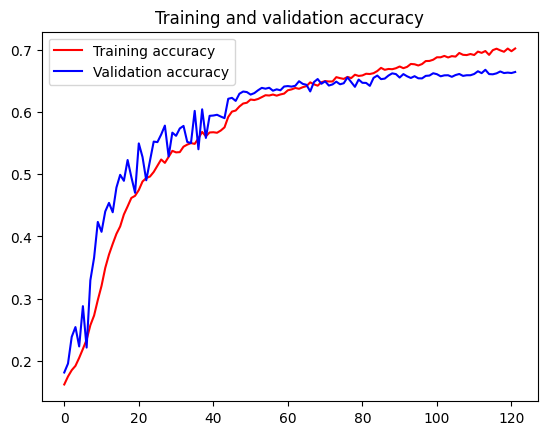

<Figure size 640x480 with 0 Axes>

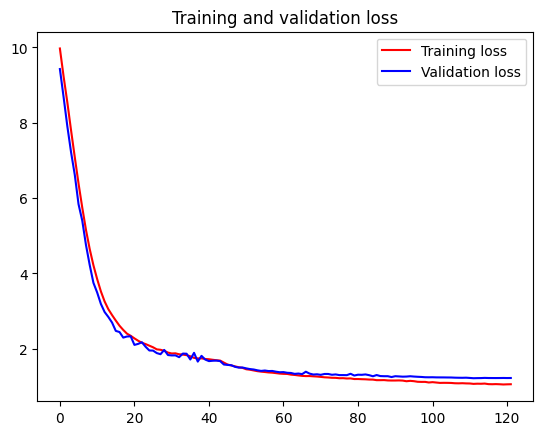

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest1_MoreData.history['accuracy']
val_acc = historytest1_MoreData.history['val_accuracy']
loss = historytest1_MoreData.history['loss']
val_loss = historytest1_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 2 CNN 66.07%

In [4]:
model8_MoreData = tf.keras.models.Sequential()   

model8_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(2, 2))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Flatten())
model8_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData.add(Dropout(0.5))
    
model8_MoreData.add(Dense(7, activation='softmax'))

model8_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

model8_MoreData.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historytest8_MoreData = model8_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 23.1789 - accuracy: 0.1733
Epoch 1: val_accuracy improved from -inf to 0.16776, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_1_0.1678.h5
371/371 [==============================] - 46s 119ms/step - loss: 23.1789 - accuracy: 0.1733 - val_loss: 21.6945 - val_accuracy: 0.1678 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 18.8375 - accuracy: 0.1986
Epoch 2: val_accuracy improved from 0.16776 to 0.27983, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_2_0.2798.h5
371/371 [==============================] - 44s 118ms/step - loss: 18.8375 - accuracy: 0.1986 - val_loss: 16.9249 - val_accuracy: 0.2798 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 14.9850 - accuracy: 0.2142
Epoch 3: val_accuracy improved from 0.27983 to 0.28759, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_3_0.

In [ ]:
model8_MoreData.evaluate(test_generator)

113/113 [==============================] - 25s 224ms/step - loss: 1.1465 - accuracy: 0.6655


[1.1464580297470093, 0.6655057072639465]

In [ ]:
model8_load = tf.keras.models.load_model(r'models/test8_MoreData/64batch\best_model_ModelPaper2_81_0.6739.h5')
model8_load.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.1677 - accuracy: 0.6608


[1.1676567792892456, 0.6607690453529358]

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model8_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 39ms/step
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       958
           1       0.52      0.72      0.60       111
           2       0.52      0.41      0.46      1024
           3       0.90      0.84      0.87      1774
           4       0.58      0.71      0.64      1233
           5       0.56      0.48      0.52      1247
           6       0.73      0.84      0.78       831

    accuracy                           0.66      7178
   macro avg       0.63      0.66      0.64      7178
weighted avg       0.66      0.66      0.66      7178

<function confusion_matrix at 0x000001D18BC96050>


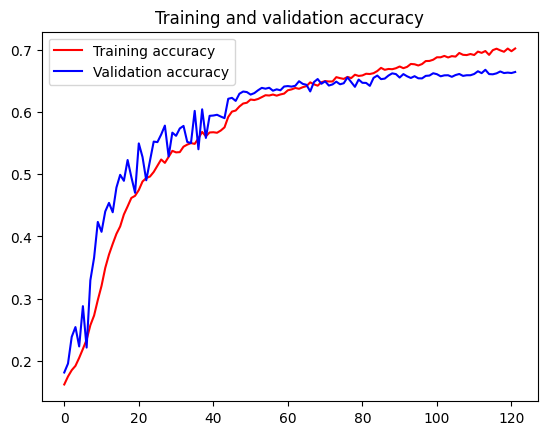

<Figure size 640x480 with 0 Axes>

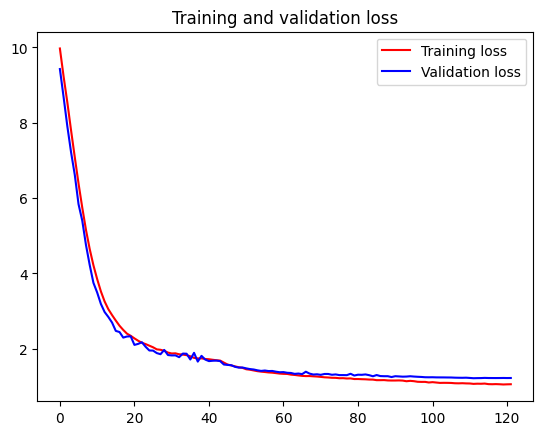

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest1_MoreData.history['accuracy']
val_acc = historytest1_MoreData.history['val_accuracy']
loss = historytest1_MoreData.history['loss']
val_loss = historytest1_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 3 CNN 65.88%

In [5]:
model13 = tf.keras.models.Sequential()

model13.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model13.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(2, 2))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Flatten())
model13.add(Dense(2048, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))
model13.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))

model13.add(Dense(7, activation='softmax'))

model13.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test13_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test13_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test13_MoreData/64batch', exist_ok=True)



log_dir = "logs/test13_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new13 = model13.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 44.8097 - accuracy: 0.1697
Epoch 1: val_accuracy improved from -inf to 0.16759, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_1_0.1676.h5
371/371 [==============================] - 47s 124ms/step - loss: 44.8097 - accuracy: 0.1697 - val_loss: 39.3375 - val_accuracy: 0.1676 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 34.0022 - accuracy: 0.1838
Epoch 2: val_accuracy improved from 0.16759 to 0.26278, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_2_0.2628.h5
371/371 [==============================] - 45s 121ms/step - loss: 34.0022 - accuracy: 0.1838 - val_loss: 28.9388 - val_accuracy: 0.2628 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 24.8431 - accuracy: 0.2016
Epoch 3: val_accuracy did not improve from 0.26278
371/371 [==============================] - 44s 120ms/step - loss: 24.8431 - 

In [ ]:
model13.evaluate(test_generator)

113/113 [==============================] - 10s 91ms/step - loss: 1.1481 - accuracy: 0.6588


[1.1480631828308105, 0.6588186025619507]

In [ ]:
model13_load = tf.keras.models.load_model(r'models/test13_MoreData/64batch\best_model_ModelPaper2_113_0.6743.h5')
model13_load.evaluate(test_generator)

113/113 [==============================] - 6s 53ms/step - loss: 1.1481 - accuracy: 0.6588


[1.1480631828308105, 0.6588186025619507]

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model13_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       958
           1       0.56      0.72      0.63       111
           2       0.53      0.39      0.45      1024
           3       0.89      0.85      0.87      1774
           4       0.57      0.71      0.63      1233
           5       0.56      0.49      0.52      1247
           6       0.74      0.80      0.77       831

    accuracy                           0.66      7178
   macro avg       0.63      0.65      0.64      7178
weighted avg       0.66      0.66      0.66      7178

<function confusion_matrix at 0x000001D18BC96050>


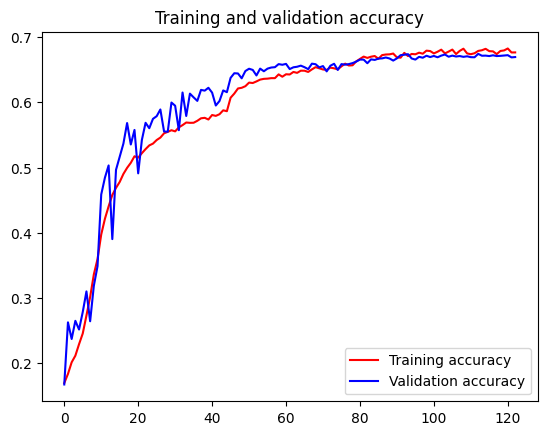

<Figure size 640x480 with 0 Axes>

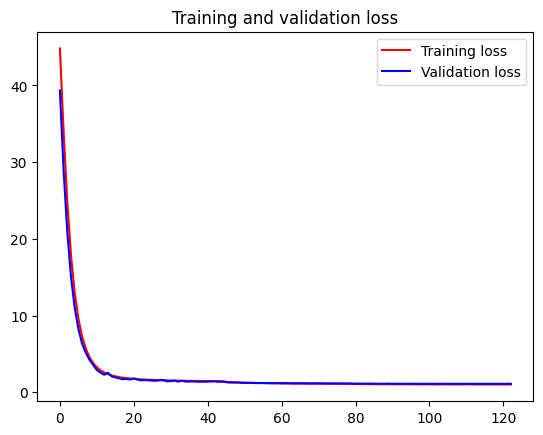

In [ ]:
import matplotlib.pyplot as plt
accuracy = historymodel_new13.history['accuracy']
val_acc = historymodel_new13.history['val_accuracy']
loss = historymodel_new13.history['loss']
val_loss = historymodel_new13.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model Keras tunner 67.62%

- Obtained by Bayesian optimization on models with one dataset

In [24]:
input = tf.keras.layers.Input(shape=(48,48,3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(input)
x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(224, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

#x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
#x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
#x = BatchNormalization()(x)
#x = MaxPooling2D(2,2)(x)
#x = Dropout(0.4)(x)


x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation="softmax")(x)

modelTunner = tf.keras.models.Model(inputs=input, outputs=output_layer)

modelTunner.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

modelTunner.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 288)       166176    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 288)      1152      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 288)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 288)       0     

In [25]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelKerasTunner/64batch', exist_ok=True)


checkpoint_path = 'models/ModelKerasTunner/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelKerasTunner/64batch', exist_ok=True)



log_dir = "logs/ModelKerasTunner/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [26]:
HistoryTunner = modelTunner.fit(
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 26.9035 - accuracy: 0.1614
Epoch 1: val_accuracy improved from -inf to 0.25046, saving model to models/ModelKerasTunner/64batch\best_model_ModelPaper2_1_0.2505.h5
371/371 [==============================] - 135s 357ms/step - loss: 26.9035 - accuracy: 0.1614 - val_loss: 25.4453 - val_accuracy: 0.2505 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 22.9100 - accuracy: 0.1640
Epoch 2: val_accuracy did not improve from 0.25046
371/371 [==============================] - 60s 163ms/step - loss: 22.9100 - accuracy: 0.1640 - val_loss: 21.3058 - val_accuracy: 0.2493 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 19.4984 - accuracy: 0.1824
Epoch 3: val_accuracy did not improve from 0.25046
371/371 [==============================] - 60s 162ms/step - loss: 19.4984 - accuracy: 0.1824 - val_loss: 18.0116 - val_accuracy: 0.2380 - lr: 1.0000e-04
Epoch 4/

In [27]:
modelTunner.evaluate(test_generator)

113/113 [==============================] - 9s 75ms/step - loss: 1.1367 - accuracy: 0.6762


[1.1367329359054565, 0.6762329339981079]

In [32]:
modelTunner.save("models/ModelKerasTunner/64batch/best_model_ModelPaper2_113_0.6762.h5")

In [30]:
modelTunner_load = tf.keras.models.load_model(r'models/ModelKerasTunner/64batch\best_model_ModelPaper2_111_0.6834.h5')
modelTunner_load.evaluate(test_generator)

113/113 [==============================] - 6s 52ms/step - loss: 1.1422 - accuracy: 0.6750


[1.1422224044799805, 0.6749790906906128]

In [6]:
modelTunner_load = tf.keras.models.load_model(r'models/ModelKerasTunner/64batch/best_model_ModelPaper2_113_0.6762.h5')
modelTunner_load.evaluate(test_generator)

113/113 [==============================] - 32s 237ms/step - loss: 1.1367 - accuracy: 0.6762


[1.1367329359054565, 0.6762329339981079]

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = modelTunner_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 48ms/step
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       958
           1       0.61      0.74      0.67       111
           2       0.57      0.42      0.48      1024
           3       0.90      0.86      0.88      1774
           4       0.60      0.69      0.64      1233
           5       0.56      0.54      0.55      1247
           6       0.75      0.83      0.79       831

    accuracy                           0.68      7178
   macro avg       0.65      0.67      0.66      7178
weighted avg       0.68      0.68      0.67      7178

<function confusion_matrix at 0x000001B10B8A9EA0>


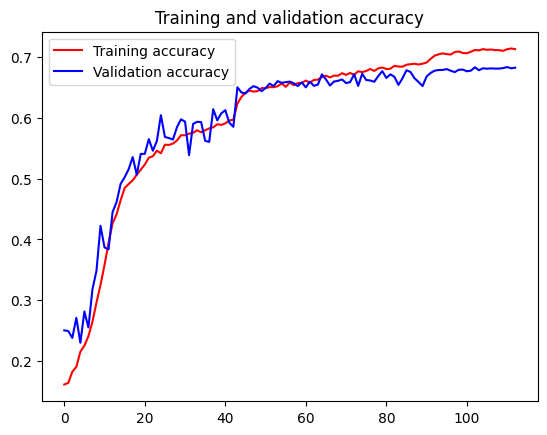

<Figure size 640x480 with 0 Axes>

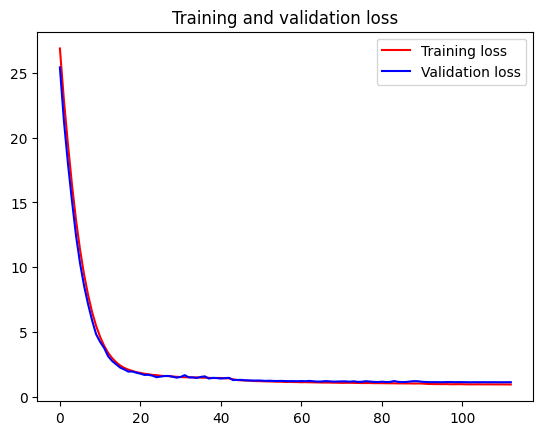

In [28]:
import matplotlib.pyplot as plt
accuracy = HistoryTunner.history['accuracy']
val_acc = HistoryTunner.history['val_accuracy']
loss = HistoryTunner.history['loss']
val_loss = HistoryTunner.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model ResNet50V2 54.34%

In [ ]:
from keras.applications import ResNet50V2
from keras.optimizers import Adamax

input_shape = (48, 48, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape) #Pre-training model with imagenet weights

model2dtResnet = Sequential([
                    #tf.keras.layers.Resizing(75,75),
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=1e-4)

model2dtResnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2dtResnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 batch_normalization_1 (Batc  (None, 2, 2, 2048)       8192      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [8]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ResNet50V22dt/64batch', exist_ok=True)


checkpoint_path = 'models/ResNet50V22dt/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ResNet50V22dt/64batch', exist_ok=True)



log_dir = "logs/ResNet50V22dt/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [9]:
history2dtResnet = model2dtResnet.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 2.2258 - accuracy: 0.1374
Epoch 1: val_accuracy improved from -inf to 0.12489, saving model to models/ResNet50V22dt/64batch\best_model_ModelPaper2_1_0.1249.h5
371/371 [==============================] - 80s 179ms/step - loss: 2.2258 - accuracy: 0.1374 - val_loss: 1.9851 - val_accuracy: 0.1249 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 2.0051 - accuracy: 0.1407
Epoch 2: val_accuracy improved from 0.12489 to 0.15781, saving model to models/ResNet50V22dt/64batch\best_model_ModelPaper2_2_0.1578.h5
371/371 [==============================] - 53s 143ms/step - loss: 2.0051 - accuracy: 0.1407 - val_loss: 1.9597 - val_accuracy: 0.1578 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 1.9725 - accuracy: 0.1465
Epoch 3: val_accuracy improved from 0.15781 to 0.17131, saving model to models/ResNet50V22dt/64batch\best_model_ModelPaper2_3_0.1713.h5
37

In [10]:
model2dtResnet.evaluate(test_generator)

113/113 [==============================] - 25s 221ms/step - loss: 1.2827 - accuracy: 0.5209


[1.282741904258728, 0.5208972096443176]

In [13]:
model2dtResnet_load = tf.keras.models.load_model(r'models/ResNet50V22dt/64batch\best_model_ModelPaper2_38_0.5480.h5')
model2dtResnet_load.evaluate(test_generator)

113/113 [==============================] - 10s 81ms/step - loss: 1.4319 - accuracy: 0.5435


[1.4319233894348145, 0.5434661507606506]

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model2dtResnet_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 6s 41ms/step
              precision    recall  f1-score   support

           0       0.39      0.48      0.43       958
           1       0.31      0.65      0.42       111
           2       0.35      0.25      0.29      1024
           3       0.83      0.74      0.78      1774
           4       0.50      0.55      0.53      1233
           5       0.45      0.36      0.40      1247
           6       0.61      0.80      0.70       831

    accuracy                           0.54      7178
   macro avg       0.49      0.55      0.51      7178
weighted avg       0.55      0.54      0.54      7178

<function confusion_matrix at 0x000001C40BA59F30>


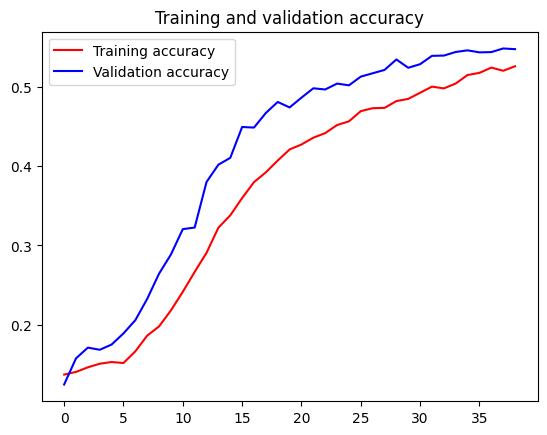

<Figure size 640x480 with 0 Axes>

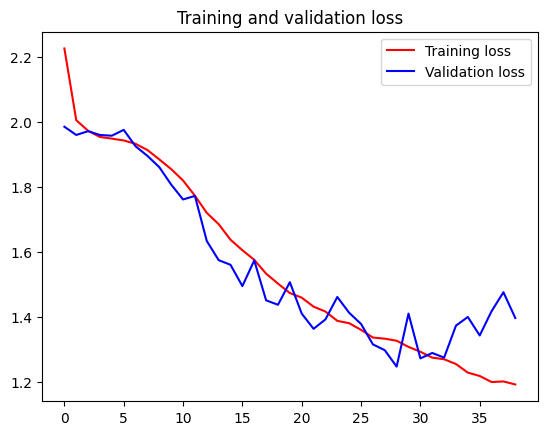

In [11]:
import matplotlib.pyplot as plt
accuracy = history2dtResnet.history['accuracy']
val_acc = history2dtResnet.history['val_accuracy']
loss = history2dtResnet.history['loss']
val_loss = history2dtResnet.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model VGG19 57.84%

In [ ]:
from keras.applications import VGG19
from keras.optimizers import Adamax

input_shape = (48, 48, 3)

base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape) #Pre-training model with imagenet weights

model2VGG19 = Sequential([
                    #tf.keras.layers.Resizing(75,75),
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adam(learning_rate=1e-4)

model2VGG19.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2VGG19.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_3 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [18]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/VGG192dt/64batch', exist_ok=True)


checkpoint_path = 'models/VGG192dt/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/VGG192dt/64batch', exist_ok=True)



log_dir = "logs/VGG192dt/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [19]:
history2dtVGG19 = model2VGG19.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 1.9207 - accuracy: 0.1811
Epoch 1: val_accuracy improved from -inf to 0.10970, saving model to models/VGG192dt/64batch\best_model_ModelPaper2_1_0.1097.h5
371/371 [==============================] - 83s 217ms/step - loss: 1.9207 - accuracy: 0.1811 - val_loss: 1.9046 - val_accuracy: 0.1097 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 1.8126 - accuracy: 0.1989
Epoch 2: val_accuracy did not improve from 0.10970
371/371 [==============================] - 62s 166ms/step - loss: 1.8126 - accuracy: 0.1989 - val_loss: 1.9196 - val_accuracy: 0.0974 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 1.7701 - accuracy: 0.2204
Epoch 3: val_accuracy improved from 0.10970 to 0.13316, saving model to models/VGG192dt/64batch\best_model_ModelPaper2_3_0.1332.h5
371/371 [==============================] - 62s 168ms/step - loss: 1.7701 - accuracy: 0.2204 - val

In [21]:
model2VGG19.evaluate(test_generator)

113/113 [==============================] - 10s 87ms/step - loss: 1.1107 - accuracy: 0.5784


[1.1107386350631714, 0.5784341096878052]

In [22]:
model2VGG19_load = tf.keras.models.load_model(r'models/VGG192dt/64batch\best_model_ModelPaper2_63_0.5985.h5')
model2VGG19_load.evaluate(test_generator)

113/113 [==============================] - 6s 47ms/step - loss: 1.1094 - accuracy: 0.5783


[1.1094114780426025, 0.5782948136329651]

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model2VGG19_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 45ms/step
              precision    recall  f1-score   support

           0       0.49      0.40      0.44       958
           1       0.44      0.68      0.54       111
           2       0.43      0.21      0.28      1024
           3       0.85      0.82      0.83      1774
           4       0.47      0.70      0.56      1233
           5       0.41      0.41      0.41      1247
           6       0.71      0.79      0.74       831

    accuracy                           0.58      7178
   macro avg       0.54      0.57      0.54      7178
weighted avg       0.58      0.58      0.57      7178

<function confusion_matrix at 0x000002188B849F30>


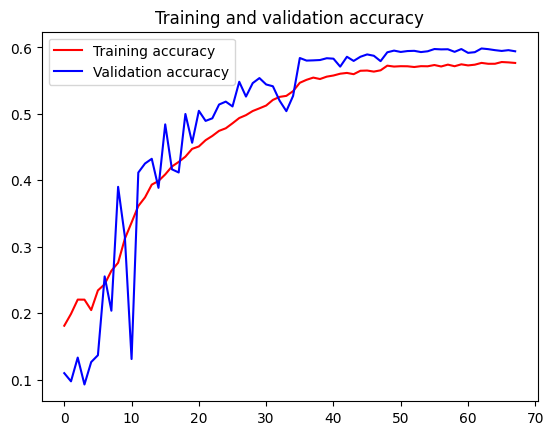

<Figure size 640x480 with 0 Axes>

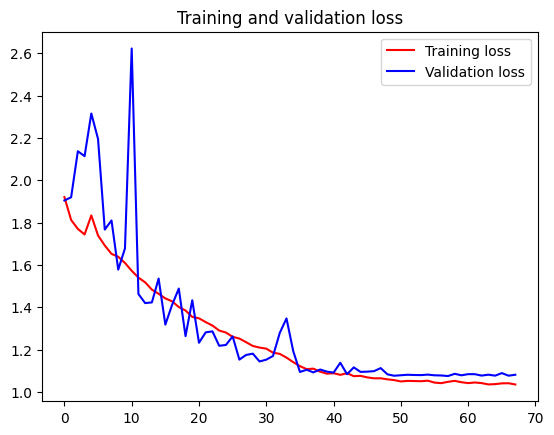

In [20]:
import matplotlib.pyplot as plt
accuracy = history2dtVGG19.history['accuracy']
val_acc = history2dtVGG19.history['val_accuracy']
loss = history2dtVGG19.history['loss']
val_loss = history2dtVGG19.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model MobileNet 58.95%

In [ ]:
from keras.applications import MobileNet
from keras.optimizers import Adamax

input_shape = (48, 48, 3)

base_model = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape) #Pre-training model with imagenet weights

model2MobileNet = Sequential([
                    #tf.keras.layers.Resizing(75,75),
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adam(learning_rate=1e-4)

model2MobileNet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2MobileNet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 1, 1, 1024)       4096      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 128)               131200    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                      

In [24]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/MobileNet2dt/64batch', exist_ok=True)


checkpoint_path = 'models/MobileNet2dt/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/MobileNet2dt/64batch', exist_ok=True)



log_dir = "logs/MobileNet2dt/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
history2dtMobileNet = model2MobileNet.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 2.5619 - accuracy: 0.1514
Epoch 1: val_accuracy improved from -inf to 0.18278, saving model to models/MobileNet2dt/64batch\best_model_ModelPaper2_1_0.1828.h5
371/371 [==============================] - 47s 120ms/step - loss: 2.5619 - accuracy: 0.1514 - val_loss: 1.9404 - val_accuracy: 0.1828 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 2.2057 - accuracy: 0.1788
Epoch 2: val_accuracy improved from 0.18278 to 0.22093, saving model to models/MobileNet2dt/64batch\best_model_ModelPaper2_2_0.2209.h5
371/371 [==============================] - 43s 115ms/step - loss: 2.2057 - accuracy: 0.1788 - val_loss: 1.8840 - val_accuracy: 0.2209 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 2.0631 - accuracy: 0.1914
Epoch 3: val_accuracy improved from 0.22093 to 0.25266, saving model to models/MobileNet2dt/64batch\best_model_ModelPaper2_3_0.2527.h5
371/3

In [27]:
model2MobileNet.evaluate(test_generator)

113/113 [==============================] - 10s 88ms/step - loss: 1.1115 - accuracy: 0.5894


[1.1114987134933472, 0.5894399285316467]

In [28]:
model2MobileNet_load = tf.keras.models.load_model(r'models/MobileNet2dt/64batch\best_model_ModelPaper2_71_0.5922.h5')
model2MobileNet_load.evaluate(test_generator)

113/113 [==============================] - 5s 39ms/step - loss: 1.1124 - accuracy: 0.5896


[1.1123685836791992, 0.5895792841911316]

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model2MobileNet_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 38ms/step
              precision    recall  f1-score   support

           0       0.44      0.58      0.50       958
           1       0.36      0.71      0.48       111
           2       0.50      0.30      0.38      1024
           3       0.85      0.77      0.81      1774
           4       0.51      0.62      0.56      1233
           5       0.51      0.39      0.44      1247
           6       0.67      0.79      0.73       831

    accuracy                           0.59      7178
   macro avg       0.55      0.60      0.56      7178
weighted avg       0.60      0.59      0.59      7178

<function confusion_matrix at 0x000002188B849F30>


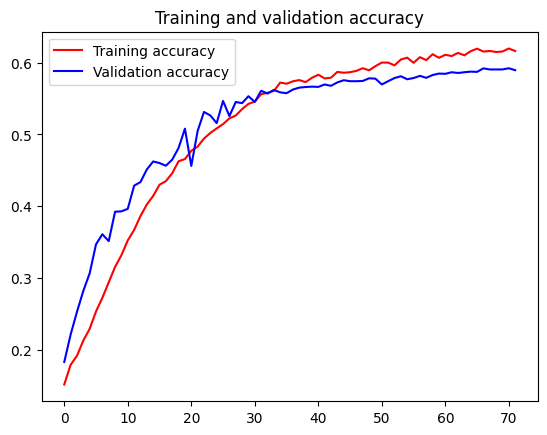

<Figure size 640x480 with 0 Axes>

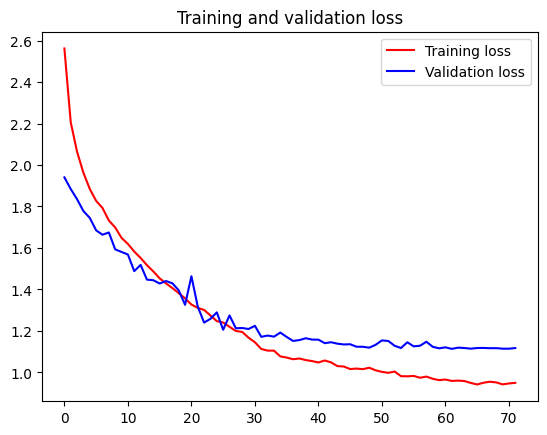

In [26]:
import matplotlib.pyplot as plt
accuracy = history2dtMobileNet.history['accuracy']
val_acc = history2dtMobileNet.history['val_accuracy']
loss = history2dtMobileNet.history['loss']
val_loss = history2dtMobileNet.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model XceptionNet 60.35%

In [ ]:
from keras.applications import Xception
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Resizing, Input
from tensorflow.keras.optimizers import Adam
from keras.regularizers import L2 


base_modelXception = Xception(weights= "imagenet", input_shape=(75,75,3), include_top=False) #Pre-training model with imagenet weights

for layer in base_modelXception.layers[:-10]:
  layer.trainable = False

input= Input(shape=(48,48,3))
input_resize = Resizing(75,75)(input) #Because the XceptionNet model requires inputs of size 75x75

x = base_modelXception(input_resize)
x = Dropout(0.50)(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)
x = GlobalAveragePooling2D()(x)

x = Dense(2048, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)

modelXception_2 = Model(inputs = input, outputs = predictions)

modelXception_2.compile(loss="categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])

modelXception_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 75, 75, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 3, 3, 2048)       8192      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 2048)        0         
                                                             

In [13]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/modelXception2dt/64batch', exist_ok=True)


checkpoint_path = 'models/modelXception2dt/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/modelXception2dt/64batch', exist_ok=True)



log_dir = "logs/modelXception2dt/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [14]:
history2dtmodelXception = modelXception_2.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 3.8703 - accuracy: 0.2747
Epoch 1: val_accuracy improved from -inf to 0.43443, saving model to models/modelXception2dt/64batch\best_model_ModelPaper2_1_0.4344.h5
371/371 [==============================] - 134s 346ms/step - loss: 3.8703 - accuracy: 0.2747 - val_loss: 3.4591 - val_accuracy: 0.4344 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 3.5184 - accuracy: 0.3607
Epoch 2: val_accuracy improved from 0.43443 to 0.45148, saving model to models/modelXception2dt/64batch\best_model_ModelPaper2_2_0.4515.h5
371/371 [==============================] - 48s 130ms/step - loss: 3.5184 - accuracy: 0.3607 - val_loss: 3.3160 - val_accuracy: 0.4515 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 3.2833 - accuracy: 0.4010
Epoch 3: val_accuracy improved from 0.45148 to 0.47848, saving model to models/modelXception2dt/64batch\best_model_ModelPaper2_3_0.

In [16]:
modelXception_2.evaluate(test_generator)

113/113 [==============================] - 14s 121ms/step - loss: 1.3651 - accuracy: 0.6035


[1.3651331663131714, 0.6035107374191284]

In [17]:
modelXception_2_load = tf.keras.models.load_model(r'models/modelXception2dt/64batch\best_model_ModelPaper2_51_0.6069.h5')
modelXception_2_load.evaluate(test_generator)

113/113 [==============================] - 8s 52ms/step - loss: 1.3541 - accuracy: 0.6028


[1.3541055917739868, 0.6028141379356384]

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = modelXception_2.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 6s 49ms/step
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       958
           1       0.59      0.67      0.62       111
           2       0.47      0.43      0.45      1024
           3       0.78      0.78      0.78      1774
           4       0.52      0.62      0.56      1233
           5       0.54      0.41      0.47      1247
           6       0.69      0.78      0.73       831

    accuracy                           0.60      7178
   macro avg       0.59      0.60      0.59      7178
weighted avg       0.60      0.60      0.60      7178

<function confusion_matrix at 0x000002188B849F30>


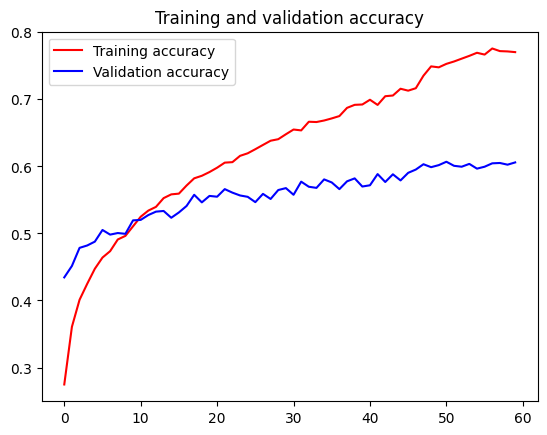

<Figure size 640x480 with 0 Axes>

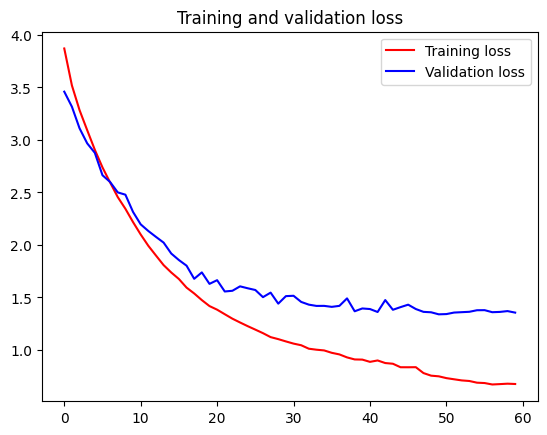

In [15]:
import matplotlib.pyplot as plt
accuracy = history2dtmodelXception.history['accuracy']
val_acc = history2dtmodelXception.history['val_accuracy']
loss = history2dtmodelXception.history['loss']
val_loss = history2dtmodelXception.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()